In [1]:
# AeroCNN-II
import os
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import datetime
%matplotlib inline

In [2]:
n_kernel=25
l2Regularizer=1e-09
kernel_size1 = 3
kernel_size2 = 5
kernel_size3 = 5
n_grid = 101
strides = 2
input_size = 49

In [3]:
alpha = np.linspace(-10,20,16).reshape((16,1))

In [4]:
aa = np.zeros((16*133,1))
for i in range(0, 133):
    aa[16*i:16*(i+1), :] = alpha[:,:]

In [5]:
aa = aa.reshape((133, 16, 1, 1))

In [6]:
os.chdir('D:\\AeroCNN2Inputs')

In [7]:
origin = "D:\\AeroCNN2Inputs"
origin_data = "D:\\AirfoilClCdCoordinates_out\\AirfoilClCdCoordinates_out"
origin_coord = "D:\\AirfoilClCdCoordinates_out\\AirfoilClCdCoordinates_out"

In [8]:
folders_orig = os.listdir(origin)
folders = [file for file in folders_orig if file.endswith('.csv')]

In [9]:
image_df = pd.DataFrame()
for i in range(1, 134):
    for j in range(0, alpha.shape[0]):
        csv_file_name = origin + '\\airfoil' + str(i) + "_alpha"+ str(int(alpha[j])) + ".csv"
        data = pd.read_csv(csv_file_name, header=None)
        image_df = pd.concat([image_df, data], axis=0)

In [10]:
image_np = image_df.iloc[:, :].values

In [11]:
image = image_np.reshape((133, 16, 100, 100))

In [12]:
cl_df = pd.DataFrame()
for i in range(1, 134):
    for alpha_ in alpha:
        cl_name = origin_coord + "\\airfoil" + str(i) + "\\"+ str(int(alpha_)) + "\\Cl_" + str(i) + "_"+ str(int(alpha_)) +".txt"
        data = pd.read_csv(cl_name, sep = ",", header=None)
        cl_df = pd.concat([cl_df, data], axis=0)

In [13]:
cd_df = pd.DataFrame()
for i in range(1, 134):
    for alpha_ in alpha:
        cd_name = origin_coord + "\\airfoil" + str(i) + "\\"+ str(int(alpha_)) + "\\Cd_" + str(i) + "_"+ str(int(alpha_)) +".txt"
        data = pd.read_csv(cd_name, sep = ",", header=None)
        cd_df = pd.concat([cd_df, data], axis=0)

In [14]:
cl = cl_df.iloc[:, :].values.reshape((-1,1))
cd = cd_df.iloc[:, :].values.reshape((-1,1))
y = np.hstack((cl, cd))

In [15]:
y = y.reshape((133, 16, 2, 1))

In [16]:
file_name = origin_data + "\\AirfoilIndexList.xlsx"
airfoilName_df = pd.read_excel(file_name)
geometry_orig = airfoilName_df.iloc[:, 1].values

In [17]:
geometry = np.zeros((133*16,1))
geometry = geometry.astype(np.string_)
for i in geometry_orig:
    index_ = np.where(geometry_orig==i)
    for j in range(0,16):
        geometry[16*index_[0]+j,:] = np.asarray(i)

In [18]:
geometry.shape

(2128, 1)

In [19]:
geometry = geometry.reshape((133, 16, 1))

In [20]:
x_train, x_test, aa_train, aa_test, geo_train, geo_test, y_train, y_test = train_test_split(image, aa, geometry, y, test_size=0.3, random_state=1)

In [21]:
x_train = x_train.reshape((x_train.shape[0]*x_train.shape[1], x_train.shape[2], x_train.shape[3], 1))
x_test = x_test.reshape((x_test.shape[0]*x_test.shape[1], x_test.shape[2], x_test.shape[3], 1))
aa_train = aa_train.reshape((aa_train.shape[0]*aa_train.shape[1], aa_train.shape[2], aa_train.shape[3]))
aa_test = aa_test.reshape((aa_test.shape[0]*aa_test.shape[1], aa_test.shape[2], aa_test.shape[3]))
geo_train = geo_train.reshape((geo_train.shape[0]*geo_train.shape[1], geo_train.shape[2]))
geo_test = geo_test.reshape((geo_test.shape[0]*geo_test.shape[1], geo_test.shape[2]))
y_train = y_train.reshape((y_train.shape[0]*y_train.shape[1], y_train.shape[2], y_train.shape[3]))
y_test = y_test.reshape((y_test.shape[0]*y_test.shape[1], y_test.shape[2], y_test.shape[3]))

In [22]:
x_train.shape

(1488, 100, 100, 1)

In [23]:
input_image = tf.keras.Input(shape=(100, 100, 1))

x_conv = tf.keras.layers.Conv2D(n_kernel, (kernel_size1, kernel_size1), strides=(strides, strides),
                                activation='relu', padding='same',
                                kernel_regularizer=tf.keras.regularizers.l2(l2Regularizer),
                                name='Conv2DLayer1')(input_image)
x_ = tf.keras.layers.MaxPooling2D((2,2))(x_conv)
x_conv = tf.keras.layers.Conv2D(n_kernel, (kernel_size2, kernel_size2), strides=(strides, strides),
                                activation='relu', padding='same',
                                kernel_regularizer=tf.keras.regularizers.l2(l2Regularizer),
                                name='Conv2DLayer2')(x_)
x_ = tf.keras.layers.MaxPooling2D((2,2))(x_conv)
x_conv = tf.keras.layers.Conv2D(n_kernel, (kernel_size3, kernel_size3), strides=(strides, strides),
                                activation='relu', padding='same',
                                kernel_regularizer=tf.keras.regularizers.l2(l2Regularizer),
                                name='Conv2DLayer3')(x_)
x_ = tf.keras.layers.MaxPooling2D((2,2))(x_conv)
reshape1 = tf.keras.layers.Flatten()(x_)

x_ = tf.keras.layers.Dense(units=200, activation='relu', name='firstHiddenLayer',
                           kernel_regularizer=tf.keras.regularizers.l2(l2Regularizer))(reshape1)
x_ = tf.keras.layers.Dense(units=100, activation='relu', name='secondHiddenLayer',
                           kernel_regularizer=tf.keras.regularizers.l2(l2Regularizer))(x_)

output_data = tf.keras.layers.Dense(units=2, activation=None, name='outputLayer')(x_)
output_image = tf.keras.layers.Reshape((2, 1))(output_data)
# AeroCNN-II
model = tf.keras.Model(input_image, output_image)

In [24]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 1)]     0         
                                                                 
 Conv2DLayer1 (Conv2D)       (None, 50, 50, 25)        250       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 25, 25)       0         
 )                                                               
                                                                 
 Conv2DLayer2 (Conv2D)       (None, 13, 13, 25)        15650     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 25)         0         
 2D)                                                             
                                                                 
 Conv2DLayer3 (Conv2D)       (None, 3, 3, 25)          15650 

In [25]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss = tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse")])

In [26]:
start = datetime.datetime.now()
history = model.fit(x_train, y_train, epochs=5000, shuffle=True)
end = datetime.datetime.now()

Epoch 1/5000
47/47 [==============================] - 4s 11ms/step - loss: 0.1010 - rmse: 0.3177
Epoch 2/5000
47/47 [==============================] - 0s 6ms/step - loss: 0.0198 - rmse: 0.1407
Epoch 3/5000
47/47 [==============================] - 0s 6ms/step - loss: 0.0145 - rmse: 0.1206
Epoch 4/5000
47/47 [==============================] - 0s 6ms/step - loss: 0.0117 - rmse: 0.1082
Epoch 5/5000
47/47 [==============================] - 0s 6ms/step - loss: 0.0104 - rmse: 0.1021
Epoch 6/5000
47/47 [==============================] - 0s 6ms/step - loss: 0.0097 - rmse: 0.0984
Epoch 7/5000
47/47 [==============================] - 0s 6ms/step - loss: 0.0093 - rmse: 0.0963
Epoch 8/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0083 - rmse: 0.0914
Epoch 9/5000
47/47 [==============================] - 0s 6ms/step - loss: 0.0075 - rmse: 0.0866
Epoch 10/5000
47/47 [==============================] - 0s 6ms/step - loss: 0.0074 - rmse: 0.0860
Epoch 11/5000
47/47 [=================

47/47 [==============================] - 0s 7ms/step - loss: 0.0037 - rmse: 0.0606
Epoch 86/5000
47/47 [==============================] - 0s 6ms/step - loss: 0.0035 - rmse: 0.0590
Epoch 87/5000
47/47 [==============================] - 0s 6ms/step - loss: 0.0030 - rmse: 0.0549
Epoch 88/5000
47/47 [==============================] - 0s 6ms/step - loss: 0.0031 - rmse: 0.0560
Epoch 89/5000
47/47 [==============================] - 0s 6ms/step - loss: 0.0029 - rmse: 0.0538
Epoch 90/5000
47/47 [==============================] - 0s 6ms/step - loss: 0.0033 - rmse: 0.0572
Epoch 91/5000
47/47 [==============================] - 0s 8ms/step - loss: 0.0031 - rmse: 0.0561
Epoch 92/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0029 - rmse: 0.0540
Epoch 93/5000
47/47 [==============================] - 0s 6ms/step - loss: 0.0036 - rmse: 0.0602
Epoch 94/5000
47/47 [==============================] - 0s 6ms/step - loss: 0.0032 - rmse: 0.0563
Epoch 95/5000
47/47 [=======================

47/47 [==============================] - 0s 7ms/step - loss: 0.0023 - rmse: 0.0484
Epoch 169/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0026 - rmse: 0.0512
Epoch 170/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0021 - rmse: 0.0453
Epoch 171/5000
47/47 [==============================] - 0s 6ms/step - loss: 0.0022 - rmse: 0.0472
Epoch 172/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0024 - rmse: 0.0488
Epoch 173/5000
47/47 [==============================] - 0s 6ms/step - loss: 0.0032 - rmse: 0.0570
Epoch 174/5000
47/47 [==============================] - 0s 8ms/step - loss: 0.0022 - rmse: 0.0467
Epoch 175/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0021 - rmse: 0.0460
Epoch 176/5000
47/47 [==============================] - 0s 6ms/step - loss: 0.0020 - rmse: 0.0445
Epoch 177/5000
47/47 [==============================] - 0s 6ms/step - loss: 0.0021 - rmse: 0.0453
Epoch 178/5000
47/47 [=============

47/47 [==============================] - 0s 7ms/step - loss: 0.0016 - rmse: 0.0402
Epoch 252/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0014 - rmse: 0.0376
Epoch 253/5000
47/47 [==============================] - 0s 6ms/step - loss: 0.0015 - rmse: 0.0391
Epoch 254/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0014 - rmse: 0.0378
Epoch 255/5000
47/47 [==============================] - 0s 8ms/step - loss: 0.0014 - rmse: 0.0369
Epoch 256/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0015 - rmse: 0.0390
Epoch 257/5000
47/47 [==============================] - 0s 6ms/step - loss: 0.0019 - rmse: 0.0438
Epoch 258/5000
47/47 [==============================] - 0s 6ms/step - loss: 0.0016 - rmse: 0.0398
Epoch 259/5000
47/47 [==============================] - 0s 6ms/step - loss: 0.0013 - rmse: 0.0360
Epoch 260/5000
47/47 [==============================] - 0s 6ms/step - loss: 0.0013 - rmse: 0.0357
Epoch 261/5000
47/47 [=============

47/47 [==============================] - 0s 6ms/step - loss: 0.0012 - rmse: 0.0346
Epoch 335/5000
47/47 [==============================] - 0s 6ms/step - loss: 0.0015 - rmse: 0.0382
Epoch 336/5000
47/47 [==============================] - 0s 6ms/step - loss: 0.0011 - rmse: 0.0332
Epoch 337/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0011 - rmse: 0.0326
Epoch 338/5000
47/47 [==============================] - 0s 8ms/step - loss: 0.0010 - rmse: 0.0322
Epoch 339/5000
47/47 [==============================] - 0s 6ms/step - loss: 0.0012 - rmse: 0.0353
Epoch 340/5000
47/47 [==============================] - 0s 6ms/step - loss: 0.0012 - rmse: 0.0345
Epoch 341/5000
47/47 [==============================] - 0s 6ms/step - loss: 0.0011 - rmse: 0.0330
Epoch 342/5000
47/47 [==============================] - 0s 6ms/step - loss: 9.6990e-04 - rmse: 0.0311
Epoch 343/5000
47/47 [==============================] - 0s 6ms/step - loss: 9.0817e-04 - rmse: 0.0301
Epoch 344/5000
47/47 [=====

47/47 [==============================] - 0s 6ms/step - loss: 8.1754e-04 - rmse: 0.0286
Epoch 416/5000
47/47 [==============================] - 0s 6ms/step - loss: 7.3456e-04 - rmse: 0.0271
Epoch 417/5000
47/47 [==============================] - 0s 6ms/step - loss: 6.5526e-04 - rmse: 0.0256
Epoch 418/5000
47/47 [==============================] - 0s 6ms/step - loss: 8.1679e-04 - rmse: 0.0286
Epoch 419/5000
47/47 [==============================] - 0s 7ms/step - loss: 8.4919e-04 - rmse: 0.0291
Epoch 420/5000
47/47 [==============================] - 0s 7ms/step - loss: 9.3583e-04 - rmse: 0.0306
Epoch 421/5000
47/47 [==============================] - 0s 6ms/step - loss: 8.8830e-04 - rmse: 0.0298
Epoch 422/5000
47/47 [==============================] - 0s 6ms/step - loss: 8.4353e-04 - rmse: 0.0290
Epoch 423/5000
47/47 [==============================] - 0s 6ms/step - loss: 7.7375e-04 - rmse: 0.0278
Epoch 424/5000
47/47 [==============================] - 0s 6ms/step - loss: 7.7785e-04 - rmse: 0.

Epoch 496/5000
47/47 [==============================] - 0s 6ms/step - loss: 7.3177e-04 - rmse: 0.0270
Epoch 497/5000
47/47 [==============================] - 0s 6ms/step - loss: 8.8431e-04 - rmse: 0.0297
Epoch 498/5000
47/47 [==============================] - 0s 6ms/step - loss: 6.8169e-04 - rmse: 0.0261
Epoch 499/5000
47/47 [==============================] - 0s 6ms/step - loss: 8.5150e-04 - rmse: 0.0292
Epoch 500/5000
47/47 [==============================] - 0s 6ms/step - loss: 6.6756e-04 - rmse: 0.0258
Epoch 501/5000
47/47 [==============================] - 0s 7ms/step - loss: 6.5253e-04 - rmse: 0.0255
Epoch 502/5000
47/47 [==============================] - 0s 8ms/step - loss: 7.1084e-04 - rmse: 0.0267
Epoch 503/5000
47/47 [==============================] - 0s 6ms/step - loss: 0.0011 - rmse: 0.0329
Epoch 504/5000
47/47 [==============================] - 0s 6ms/step - loss: 8.7317e-04 - rmse: 0.0295
Epoch 505/5000
47/47 [==============================] - 0s 6ms/step - loss: 6.0342e-04

47/47 [==============================] - 0s 6ms/step - loss: 5.0473e-04 - rmse: 0.0225
Epoch 577/5000
47/47 [==============================] - 0s 8ms/step - loss: 8.5557e-04 - rmse: 0.0292
Epoch 578/5000
47/47 [==============================] - 0s 7ms/step - loss: 6.2703e-04 - rmse: 0.0250
Epoch 579/5000
47/47 [==============================] - 0s 6ms/step - loss: 6.7756e-04 - rmse: 0.0260
Epoch 580/5000
47/47 [==============================] - 0s 6ms/step - loss: 5.3539e-04 - rmse: 0.0231
Epoch 581/5000
47/47 [==============================] - 0s 6ms/step - loss: 5.7538e-04 - rmse: 0.0240
Epoch 582/5000
47/47 [==============================] - 0s 6ms/step - loss: 4.9391e-04 - rmse: 0.0222
Epoch 583/5000
47/47 [==============================] - 0s 6ms/step - loss: 5.6325e-04 - rmse: 0.0237
Epoch 584/5000
47/47 [==============================] - 0s 8ms/step - loss: 7.0244e-04 - rmse: 0.0265
Epoch 585/5000
47/47 [==============================] - 0s 7ms/step - loss: 5.0287e-04 - rmse: 0.

47/47 [==============================] - 0s 7ms/step - loss: 5.4159e-04 - rmse: 0.0233
Epoch 657/5000
47/47 [==============================] - 0s 8ms/step - loss: 5.7731e-04 - rmse: 0.0240
Epoch 658/5000
47/47 [==============================] - 0s 7ms/step - loss: 6.5317e-04 - rmse: 0.0256
Epoch 659/5000
47/47 [==============================] - 0s 6ms/step - loss: 6.3616e-04 - rmse: 0.0252
Epoch 660/5000
47/47 [==============================] - 0s 6ms/step - loss: 5.2331e-04 - rmse: 0.0229
Epoch 661/5000
47/47 [==============================] - 0s 6ms/step - loss: 4.5315e-04 - rmse: 0.0213
Epoch 662/5000
47/47 [==============================] - 0s 6ms/step - loss: 5.0582e-04 - rmse: 0.0225
Epoch 663/5000
47/47 [==============================] - 0s 7ms/step - loss: 8.0232e-04 - rmse: 0.0283
Epoch 664/5000
47/47 [==============================] - 0s 8ms/step - loss: 5.1130e-04 - rmse: 0.0226
Epoch 665/5000
47/47 [==============================] - 0s 6ms/step - loss: 5.3185e-04 - rmse: 0.

47/47 [==============================] - 0s 7ms/step - loss: 5.7057e-04 - rmse: 0.0239
Epoch 737/5000
47/47 [==============================] - 0s 7ms/step - loss: 7.0410e-04 - rmse: 0.0265
Epoch 738/5000
47/47 [==============================] - 0s 8ms/step - loss: 7.4192e-04 - rmse: 0.0272
Epoch 739/5000
47/47 [==============================] - 0s 6ms/step - loss: 7.4021e-04 - rmse: 0.0272
Epoch 740/5000
47/47 [==============================] - 0s 6ms/step - loss: 4.8689e-04 - rmse: 0.0221
Epoch 741/5000
47/47 [==============================] - 0s 6ms/step - loss: 4.1180e-04 - rmse: 0.0203
Epoch 742/5000
47/47 [==============================] - 0s 6ms/step - loss: 5.6902e-04 - rmse: 0.0238
Epoch 743/5000
47/47 [==============================] - 0s 6ms/step - loss: 3.9090e-04 - rmse: 0.0198
Epoch 744/5000
47/47 [==============================] - 0s 7ms/step - loss: 4.1649e-04 - rmse: 0.0204
Epoch 745/5000
47/47 [==============================] - 0s 7ms/step - loss: 4.0025e-04 - rmse: 0.

47/47 [==============================] - 0s 6ms/step - loss: 5.7527e-04 - rmse: 0.0240
Epoch 817/5000
47/47 [==============================] - 0s 6ms/step - loss: 4.2666e-04 - rmse: 0.0206
Epoch 818/5000
47/47 [==============================] - 0s 7ms/step - loss: 6.2074e-04 - rmse: 0.0249
Epoch 819/5000
47/47 [==============================] - 0s 7ms/step - loss: 3.6908e-04 - rmse: 0.0192
Epoch 820/5000
47/47 [==============================] - 0s 7ms/step - loss: 5.0990e-04 - rmse: 0.0226
Epoch 821/5000
47/47 [==============================] - 0s 7ms/step - loss: 3.7143e-04 - rmse: 0.0193
Epoch 822/5000
47/47 [==============================] - 0s 7ms/step - loss: 4.2517e-04 - rmse: 0.0206
Epoch 823/5000
47/47 [==============================] - 0s 7ms/step - loss: 4.0975e-04 - rmse: 0.0202
Epoch 824/5000
47/47 [==============================] - 0s 8ms/step - loss: 4.6999e-04 - rmse: 0.0217
Epoch 825/5000
47/47 [==============================] - 0s 7ms/step - loss: 3.3556e-04 - rmse: 0.

47/47 [==============================] - 0s 6ms/step - loss: 4.5559e-04 - rmse: 0.0213
Epoch 897/5000
47/47 [==============================] - 0s 8ms/step - loss: 4.8412e-04 - rmse: 0.0220
Epoch 898/5000
47/47 [==============================] - 0s 7ms/step - loss: 3.7312e-04 - rmse: 0.0193
Epoch 899/5000
47/47 [==============================] - 0s 6ms/step - loss: 4.2536e-04 - rmse: 0.0206
Epoch 900/5000
47/47 [==============================] - 0s 6ms/step - loss: 3.2597e-04 - rmse: 0.0180
Epoch 901/5000
47/47 [==============================] - 0s 6ms/step - loss: 4.6970e-04 - rmse: 0.0217
Epoch 902/5000
47/47 [==============================] - 0s 6ms/step - loss: 4.7880e-04 - rmse: 0.0219
Epoch 903/5000
47/47 [==============================] - 0s 6ms/step - loss: 3.7808e-04 - rmse: 0.0194
Epoch 904/5000
47/47 [==============================] - 0s 8ms/step - loss: 4.2947e-04 - rmse: 0.0207
Epoch 905/5000
47/47 [==============================] - 0s 7ms/step - loss: 3.5827e-04 - rmse: 0.

47/47 [==============================] - 0s 6ms/step - loss: 3.1564e-04 - rmse: 0.0178
Epoch 977/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.8696e-04 - rmse: 0.0169
Epoch 978/5000
47/47 [==============================] - 0s 7ms/step - loss: 3.9608e-04 - rmse: 0.0199
Epoch 979/5000
47/47 [==============================] - 0s 7ms/step - loss: 3.6729e-04 - rmse: 0.0192
Epoch 980/5000
47/47 [==============================] - 0s 7ms/step - loss: 4.3241e-04 - rmse: 0.0208
Epoch 981/5000
47/47 [==============================] - 0s 7ms/step - loss: 3.5722e-04 - rmse: 0.0189
Epoch 982/5000
47/47 [==============================] - 0s 7ms/step - loss: 3.2144e-04 - rmse: 0.0179
Epoch 983/5000
47/47 [==============================] - 0s 7ms/step - loss: 2.9359e-04 - rmse: 0.0171
Epoch 984/5000
47/47 [==============================] - 0s 7ms/step - loss: 3.3934e-04 - rmse: 0.0184
Epoch 985/5000
47/47 [==============================] - 0s 8ms/step - loss: 3.6639e-04 - rmse: 0.

47/47 [==============================] - 0s 6ms/step - loss: 4.6345e-04 - rmse: 0.0215
Epoch 1056/5000
47/47 [==============================] - 0s 6ms/step - loss: 3.4514e-04 - rmse: 0.0186
Epoch 1057/5000
47/47 [==============================] - 0s 6ms/step - loss: 3.5604e-04 - rmse: 0.0189
Epoch 1058/5000
47/47 [==============================] - 0s 7ms/step - loss: 3.3584e-04 - rmse: 0.0183
Epoch 1059/5000
47/47 [==============================] - 0s 8ms/step - loss: 3.9466e-04 - rmse: 0.0199
Epoch 1060/5000
47/47 [==============================] - 0s 6ms/step - loss: 3.4157e-04 - rmse: 0.0185
Epoch 1061/5000
47/47 [==============================] - 0s 6ms/step - loss: 3.0834e-04 - rmse: 0.0176
Epoch 1062/5000
47/47 [==============================] - 0s 6ms/step - loss: 3.1844e-04 - rmse: 0.0178
Epoch 1063/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.8984e-04 - rmse: 0.0170
Epoch 1064/5000
47/47 [==============================] - 0s 6ms/step - loss: 3.6192e-04 -

47/47 [==============================] - 0s 6ms/step - loss: 2.8891e-04 - rmse: 0.0170
Epoch 1135/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.4601e-04 - rmse: 0.0157
Epoch 1136/5000
47/47 [==============================] - 0s 6ms/step - loss: 3.8013e-04 - rmse: 0.0195
Epoch 1137/5000
47/47 [==============================] - 0s 6ms/step - loss: 3.3750e-04 - rmse: 0.0184
Epoch 1138/5000
47/47 [==============================] - 0s 6ms/step - loss: 8.9736e-04 - rmse: 0.0300
Epoch 1139/5000
47/47 [==============================] - 0s 7ms/step - loss: 4.2741e-04 - rmse: 0.0207
Epoch 1140/5000
47/47 [==============================] - 0s 8ms/step - loss: 3.5629e-04 - rmse: 0.0189
Epoch 1141/5000
47/47 [==============================] - 0s 6ms/step - loss: 3.5276e-04 - rmse: 0.0188
Epoch 1142/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.9330e-04 - rmse: 0.0171
Epoch 1143/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.5332e-04 -

47/47 [==============================] - 0s 7ms/step - loss: 3.1535e-04 - rmse: 0.0178
Epoch 1214/5000
47/47 [==============================] - 0s 8ms/step - loss: 2.6683e-04 - rmse: 0.0163
Epoch 1215/5000
47/47 [==============================] - 0s 7ms/step - loss: 2.7066e-04 - rmse: 0.0164
Epoch 1216/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.9874e-04 - rmse: 0.0173
Epoch 1217/5000
47/47 [==============================] - 0s 6ms/step - loss: 3.4128e-04 - rmse: 0.0185
Epoch 1218/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.9241e-04 - rmse: 0.0171
Epoch 1219/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.8363e-04 - rmse: 0.0168
Epoch 1220/5000
47/47 [==============================] - 0s 7ms/step - loss: 2.8711e-04 - rmse: 0.0169
Epoch 1221/5000
47/47 [==============================] - 0s 8ms/step - loss: 3.6019e-04 - rmse: 0.0190
Epoch 1222/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.8050e-04 -

47/47 [==============================] - 0s 6ms/step - loss: 2.3210e-04 - rmse: 0.0152
Epoch 1293/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.8485e-04 - rmse: 0.0169
Epoch 1294/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.3823e-04 - rmse: 0.0154
Epoch 1295/5000
47/47 [==============================] - 0s 7ms/step - loss: 2.3497e-04 - rmse: 0.0153
Epoch 1296/5000
47/47 [==============================] - 0s 7ms/step - loss: 2.6735e-04 - rmse: 0.0163
Epoch 1297/5000
47/47 [==============================] - 0s 7ms/step - loss: 2.4625e-04 - rmse: 0.0157
Epoch 1298/5000
47/47 [==============================] - 0s 7ms/step - loss: 2.1413e-04 - rmse: 0.0146
Epoch 1299/5000
47/47 [==============================] - 0s 7ms/step - loss: 2.7786e-04 - rmse: 0.0167
Epoch 1300/5000
47/47 [==============================] - 0s 7ms/step - loss: 2.5840e-04 - rmse: 0.0161
Epoch 1301/5000
47/47 [==============================] - 0s 8ms/step - loss: 3.2238e-04 -

47/47 [==============================] - 0s 7ms/step - loss: 2.4862e-04 - rmse: 0.0158
Epoch 1372/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.4541e-04 - rmse: 0.0157
Epoch 1373/5000
47/47 [==============================] - 0s 7ms/step - loss: 4.1897e-04 - rmse: 0.0205
Epoch 1374/5000
47/47 [==============================] - 0s 8ms/step - loss: 3.2738e-04 - rmse: 0.0181
Epoch 1375/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.6438e-04 - rmse: 0.0163
Epoch 1376/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.6476e-04 - rmse: 0.0163
Epoch 1377/5000
47/47 [==============================] - 0s 6ms/step - loss: 3.2626e-04 - rmse: 0.0181
Epoch 1378/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.6666e-04 - rmse: 0.0163
Epoch 1379/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.9080e-04 - rmse: 0.0170
Epoch 1380/5000
47/47 [==============================] - 0s 7ms/step - loss: 2.5100e-04 -

47/47 [==============================] - 0s 6ms/step - loss: 2.7646e-04 - rmse: 0.0166
Epoch 1451/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.3328e-04 - rmse: 0.0153
Epoch 1452/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.9095e-04 - rmse: 0.0170
Epoch 1453/5000
47/47 [==============================] - 0s 6ms/step - loss: 3.1392e-04 - rmse: 0.0177
Epoch 1454/5000
47/47 [==============================] - 0s 7ms/step - loss: 2.6898e-04 - rmse: 0.0164
Epoch 1455/5000
47/47 [==============================] - 0s 8ms/step - loss: 2.9677e-04 - rmse: 0.0172
Epoch 1456/5000
47/47 [==============================] - 0s 6ms/step - loss: 3.0436e-04 - rmse: 0.0174
Epoch 1457/5000
47/47 [==============================] - 0s 6ms/step - loss: 9.3189e-04 - rmse: 0.0305
Epoch 1458/5000
47/47 [==============================] - 0s 6ms/step - loss: 0.0022 - rmse: 0.0470
Epoch 1459/5000
47/47 [==============================] - 0s 6ms/step - loss: 0.0042 - rmse: 0

47/47 [==============================] - 0s 7ms/step - loss: 2.9540e-04 - rmse: 0.0172
Epoch 1530/5000
47/47 [==============================] - 0s 7ms/step - loss: 3.5814e-04 - rmse: 0.0189
Epoch 1531/5000
47/47 [==============================] - 0s 8ms/step - loss: 3.0346e-04 - rmse: 0.0174
Epoch 1532/5000
47/47 [==============================] - 0s 6ms/step - loss: 3.0507e-04 - rmse: 0.0175
Epoch 1533/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.3757e-04 - rmse: 0.0154
Epoch 1534/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.5871e-04 - rmse: 0.0161
Epoch 1535/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.8846e-04 - rmse: 0.0170
Epoch 1536/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.0660e-04 - rmse: 0.0144
Epoch 1537/5000
47/47 [==============================] - 0s 8ms/step - loss: 2.7622e-04 - rmse: 0.0166
Epoch 1538/5000
47/47 [==============================] - 0s 7ms/step - loss: 2.7891e-04 -

47/47 [==============================] - 0s 6ms/step - loss: 1.8865e-04 - rmse: 0.0137
Epoch 1609/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.6783e-04 - rmse: 0.0164
Epoch 1610/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.2059e-04 - rmse: 0.0148
Epoch 1611/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.8992e-04 - rmse: 0.0170
Epoch 1612/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.4636e-04 - rmse: 0.0157
Epoch 1613/5000
47/47 [==============================] - 0s 8ms/step - loss: 2.7549e-04 - rmse: 0.0166
Epoch 1614/5000
47/47 [==============================] - 0s 7ms/step - loss: 4.2613e-04 - rmse: 0.0206
Epoch 1615/5000
47/47 [==============================] - 0s 7ms/step - loss: 3.7505e-04 - rmse: 0.0194
Epoch 1616/5000
47/47 [==============================] - 0s 7ms/step - loss: 2.9132e-04 - rmse: 0.0171
Epoch 1617/5000
47/47 [==============================] - 0s 7ms/step - loss: 3.3016e-04 -

47/47 [==============================] - 0s 8ms/step - loss: 2.2974e-04 - rmse: 0.0151
Epoch 1688/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.9689e-04 - rmse: 0.0172
Epoch 1689/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.1768e-04 - rmse: 0.0147
Epoch 1690/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.9373e-04 - rmse: 0.0139
Epoch 1691/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.1430e-04 - rmse: 0.0146
Epoch 1692/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.0410e-04 - rmse: 0.0143
Epoch 1693/5000
47/47 [==============================] - 0s 7ms/step - loss: 2.1611e-04 - rmse: 0.0147
Epoch 1694/5000
47/47 [==============================] - 0s 8ms/step - loss: 2.1800e-04 - rmse: 0.0148
Epoch 1695/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.1489e-04 - rmse: 0.0146
Epoch 1696/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.4890e-04 -

47/47 [==============================] - 0s 6ms/step - loss: 1.9458e-04 - rmse: 0.0139
Epoch 1767/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.8599e-04 - rmse: 0.0169
Epoch 1768/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.3089e-04 - rmse: 0.0152
Epoch 1769/5000
47/47 [==============================] - 0s 8ms/step - loss: 2.1954e-04 - rmse: 0.0148
Epoch 1770/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.7028e-04 - rmse: 0.0130
Epoch 1771/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.4107e-04 - rmse: 0.0155
Epoch 1772/5000
47/47 [==============================] - 0s 7ms/step - loss: 5.2446e-04 - rmse: 0.0229
Epoch 1773/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0012 - rmse: 0.0351
Epoch 1774/5000
47/47 [==============================] - 0s 6ms/step - loss: 9.8676e-04 - rmse: 0.0314
Epoch 1775/5000
47/47 [==============================] - 0s 7ms/step - loss: 4.1487e-04 - rms

47/47 [==============================] - 0s 8ms/step - loss: 2.6014e-04 - rmse: 0.0161
Epoch 1846/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.5514e-04 - rmse: 0.0160
Epoch 1847/5000
47/47 [==============================] - 0s 6ms/step - loss: 4.0015e-04 - rmse: 0.0200
Epoch 1848/5000
47/47 [==============================] - 0s 6ms/step - loss: 4.8366e-04 - rmse: 0.0220
Epoch 1849/5000
47/47 [==============================] - 0s 6ms/step - loss: 4.0477e-04 - rmse: 0.0201
Epoch 1850/5000
47/47 [==============================] - 0s 6ms/step - loss: 0.0015 - rmse: 0.0385
Epoch 1851/5000
47/47 [==============================] - 0s 6ms/step - loss: 5.5328e-04 - rmse: 0.0235
Epoch 1852/5000
47/47 [==============================] - 0s 8ms/step - loss: 2.9943e-04 - rmse: 0.0173
Epoch 1853/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.8582e-04 - rmse: 0.0136
Epoch 1854/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.7440e-04 - rms

47/47 [==============================] - 0s 6ms/step - loss: 1.8451e-04 - rmse: 0.0136
Epoch 1925/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.6311e-04 - rmse: 0.0128
Epoch 1926/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.2956e-04 - rmse: 0.0151
Epoch 1927/5000
47/47 [==============================] - 0s 7ms/step - loss: 2.1453e-04 - rmse: 0.0146
Epoch 1928/5000
47/47 [==============================] - 0s 8ms/step - loss: 2.4216e-04 - rmse: 0.0156
Epoch 1929/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.8547e-04 - rmse: 0.0136
Epoch 1930/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.2808e-04 - rmse: 0.0151
Epoch 1931/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.6738e-04 - rmse: 0.0129
Epoch 1932/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.4445e-04 - rmse: 0.0156
Epoch 1933/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.6925e-04 -

47/47 [==============================] - 0s 8ms/step - loss: 2.4966e-04 - rmse: 0.0158
Epoch 2004/5000
47/47 [==============================] - 0s 7ms/step - loss: 2.3951e-04 - rmse: 0.0155
Epoch 2005/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.2279e-04 - rmse: 0.0149
Epoch 2006/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.5827e-04 - rmse: 0.0126
Epoch 2007/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.7371e-04 - rmse: 0.0165
Epoch 2008/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.5379e-04 - rmse: 0.0159
Epoch 2009/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.5804e-04 - rmse: 0.0126
Epoch 2010/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.4751e-04 - rmse: 0.0121
Epoch 2011/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.4627e-04 - rmse: 0.0121
Epoch 2012/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.3612e-04 -

47/47 [==============================] - 0s 6ms/step - loss: 2.3109e-04 - rmse: 0.0152
Epoch 2083/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.0957e-04 - rmse: 0.0145
Epoch 2084/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.7090e-04 - rmse: 0.0165
Epoch 2085/5000
47/47 [==============================] - 0s 7ms/step - loss: 2.3294e-04 - rmse: 0.0153
Epoch 2086/5000
47/47 [==============================] - 0s 8ms/step - loss: 2.0505e-04 - rmse: 0.0143
Epoch 2087/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.3215e-04 - rmse: 0.0115
Epoch 2088/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.2758e-04 - rmse: 0.0151
Epoch 2089/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.6513e-04 - rmse: 0.0128
Epoch 2090/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.3660e-04 - rmse: 0.0117
Epoch 2091/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.3409e-04 -

47/47 [==============================] - 0s 7ms/step - loss: 1.8776e-04 - rmse: 0.0137
Epoch 2162/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.7193e-04 - rmse: 0.0131
Epoch 2163/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.9756e-04 - rmse: 0.0140
Epoch 2164/5000
47/47 [==============================] - 0s 7ms/step - loss: 2.2630e-04 - rmse: 0.0150
Epoch 2165/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.7421e-04 - rmse: 0.0132
Epoch 2166/5000
47/47 [==============================] - 0s 7ms/step - loss: 2.6272e-04 - rmse: 0.0162
Epoch 2167/5000
47/47 [==============================] - 0s 8ms/step - loss: 2.1903e-04 - rmse: 0.0148
Epoch 2168/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.6806e-04 - rmse: 0.0130
Epoch 2169/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.0689e-04 - rmse: 0.0144
Epoch 2170/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.8150e-04 -

47/47 [==============================] - 0s 6ms/step - loss: 1.6657e-04 - rmse: 0.0129
Epoch 2241/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.1102e-04 - rmse: 0.0145
Epoch 2242/5000
47/47 [==============================] - 0s 8ms/step - loss: 2.3850e-04 - rmse: 0.0154
Epoch 2243/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.6346e-04 - rmse: 0.0162
Epoch 2244/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.3285e-04 - rmse: 0.0153
Epoch 2245/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.9435e-04 - rmse: 0.0139
Epoch 2246/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.9061e-04 - rmse: 0.0170
Epoch 2247/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.8490e-04 - rmse: 0.0169
Epoch 2248/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.4666e-04 - rmse: 0.0157
Epoch 2249/5000
47/47 [==============================] - 0s 8ms/step - loss: 2.0120e-04 -

47/47 [==============================] - 0s 6ms/step - loss: 1.3586e-04 - rmse: 0.0116
Epoch 2320/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.3030e-04 - rmse: 0.0152
Epoch 2321/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.4025e-04 - rmse: 0.0155
Epoch 2322/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.5098e-04 - rmse: 0.0158
Epoch 2323/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.5639e-04 - rmse: 0.0160
Epoch 2324/5000
47/47 [==============================] - 0s 7ms/step - loss: 2.0234e-04 - rmse: 0.0142
Epoch 2325/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.0229e-04 - rmse: 0.0142
Epoch 2326/5000
47/47 [==============================] - 0s 7ms/step - loss: 2.2381e-04 - rmse: 0.0150
Epoch 2327/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.6527e-04 - rmse: 0.0163
Epoch 2328/5000
47/47 [==============================] - 0s 7ms/step - loss: 3.1691e-04 -

47/47 [==============================] - 0s 6ms/step - loss: 1.6923e-04 - rmse: 0.0130
Epoch 2399/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.3344e-04 - rmse: 0.0115
Epoch 2400/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.3184e-04 - rmse: 0.0152
Epoch 2401/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.8934e-04 - rmse: 0.0137
Epoch 2402/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.8208e-04 - rmse: 0.0135
Epoch 2403/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.5783e-04 - rmse: 0.0126
Epoch 2404/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.3605e-04 - rmse: 0.0117
Epoch 2405/5000
47/47 [==============================] - 0s 8ms/step - loss: 1.2106e-04 - rmse: 0.0110
Epoch 2406/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.7711e-04 - rmse: 0.0133
Epoch 2407/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.2047e-04 -

47/47 [==============================] - 0s 6ms/step - loss: 1.5834e-04 - rmse: 0.0126
Epoch 2478/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.2768e-04 - rmse: 0.0113
Epoch 2479/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.6796e-04 - rmse: 0.0129
Epoch 2480/5000
47/47 [==============================] - 0s 8ms/step - loss: 1.8084e-04 - rmse: 0.0134
Epoch 2481/5000
47/47 [==============================] - 0s 7ms/step - loss: 2.5262e-04 - rmse: 0.0159
Epoch 2482/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.5375e-04 - rmse: 0.0124
Epoch 2483/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.2799e-04 - rmse: 0.0113
Epoch 2484/5000
47/47 [==============================] - 0s 6ms/step - loss: 9.5915e-05 - rmse: 0.0098
Epoch 2485/5000
47/47 [==============================] - 0s 6ms/step - loss: 9.3615e-05 - rmse: 0.0097
Epoch 2486/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.0679e-04 -

47/47 [==============================] - 0s 7ms/step - loss: 5.6789e-04 - rmse: 0.0238
Epoch 2557/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.3952e-04 - rmse: 0.0155
Epoch 2558/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.3637e-04 - rmse: 0.0117
Epoch 2559/5000
47/47 [==============================] - 0s 6ms/step - loss: 9.7528e-05 - rmse: 0.0099
Epoch 2560/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.0205e-04 - rmse: 0.0101
Epoch 2561/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.6186e-04 - rmse: 0.0127
Epoch 2562/5000
47/47 [==============================] - 0s 8ms/step - loss: 9.4012e-05 - rmse: 0.0097
Epoch 2563/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.1100e-04 - rmse: 0.0105
Epoch 2564/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.5220e-04 - rmse: 0.0123
Epoch 2565/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.1197e-04 -

47/47 [==============================] - 0s 6ms/step - loss: 1.8145e-04 - rmse: 0.0135
Epoch 2636/5000
47/47 [==============================] - 0s 7ms/step - loss: 3.1879e-04 - rmse: 0.0178
Epoch 2637/5000
47/47 [==============================] - 0s 8ms/step - loss: 2.6976e-04 - rmse: 0.0164
Epoch 2638/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.3762e-04 - rmse: 0.0117
Epoch 2639/5000
47/47 [==============================] - 0s 6ms/step - loss: 9.1233e-05 - rmse: 0.0095
Epoch 2640/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.1849e-04 - rmse: 0.0109
Epoch 2641/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.4966e-04 - rmse: 0.0122
Epoch 2642/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.5168e-04 - rmse: 0.0159
Epoch 2643/5000
47/47 [==============================] - 0s 8ms/step - loss: 2.1961e-04 - rmse: 0.0148
Epoch 2644/5000
47/47 [==============================] - 0s 7ms/step - loss: 2.2409e-04 -

47/47 [==============================] - 0s 6ms/step - loss: 8.4381e-05 - rmse: 0.0092
Epoch 2715/5000
47/47 [==============================] - 0s 6ms/step - loss: 7.3887e-05 - rmse: 0.0086
Epoch 2716/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.1180e-04 - rmse: 0.0106
Epoch 2717/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.0908e-04 - rmse: 0.0144
Epoch 2718/5000
47/47 [==============================] - 0s 8ms/step - loss: 5.7258e-04 - rmse: 0.0239
Epoch 2719/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.9521e-04 - rmse: 0.0140
Epoch 2720/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.3161e-04 - rmse: 0.0115
Epoch 2721/5000
47/47 [==============================] - 0s 6ms/step - loss: 9.4225e-05 - rmse: 0.0097
Epoch 2722/5000
47/47 [==============================] - 0s 6ms/step - loss: 9.5380e-05 - rmse: 0.0098
Epoch 2723/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.2095e-04 -

47/47 [==============================] - 0s 6ms/step - loss: 1.5103e-04 - rmse: 0.0123
Epoch 2794/5000
47/47 [==============================] - 0s 8ms/step - loss: 1.6104e-04 - rmse: 0.0127
Epoch 2795/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.0929e-04 - rmse: 0.0104
Epoch 2796/5000
47/47 [==============================] - 0s 7ms/step - loss: 8.9725e-05 - rmse: 0.0095
Epoch 2797/5000
47/47 [==============================] - 0s 6ms/step - loss: 9.5403e-05 - rmse: 0.0098
Epoch 2798/5000
47/47 [==============================] - 0s 6ms/step - loss: 9.3887e-05 - rmse: 0.0097
Epoch 2799/5000
47/47 [==============================] - 0s 7ms/step - loss: 8.4814e-05 - rmse: 0.0092
Epoch 2800/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.0231e-04 - rmse: 0.0101
Epoch 2801/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.2788e-04 - rmse: 0.0113
Epoch 2802/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.5928e-04 -

47/47 [==============================] - 0s 6ms/step - loss: 1.1970e-04 - rmse: 0.0109
Epoch 2873/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.0724e-04 - rmse: 0.0103
Epoch 2874/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.1816e-04 - rmse: 0.0109
Epoch 2875/5000
47/47 [==============================] - 0s 8ms/step - loss: 1.5010e-04 - rmse: 0.0122
Epoch 2876/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.3668e-04 - rmse: 0.0117
Epoch 2877/5000
47/47 [==============================] - 0s 6ms/step - loss: 8.5998e-05 - rmse: 0.0093
Epoch 2878/5000
47/47 [==============================] - 0s 6ms/step - loss: 8.5341e-05 - rmse: 0.0092
Epoch 2879/5000
47/47 [==============================] - 0s 6ms/step - loss: 9.3900e-05 - rmse: 0.0097
Epoch 2880/5000
47/47 [==============================] - 0s 6ms/step - loss: 8.3844e-05 - rmse: 0.0091
Epoch 2881/5000
47/47 [==============================] - 0s 6ms/step - loss: 8.1185e-05 -

47/47 [==============================] - 0s 7ms/step - loss: 1.4486e-04 - rmse: 0.0120
Epoch 2952/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.3447e-04 - rmse: 0.0116
Epoch 2953/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.1174e-04 - rmse: 0.0145
Epoch 2954/5000
47/47 [==============================] - 0s 7ms/step - loss: 2.0501e-04 - rmse: 0.0143
Epoch 2955/5000
47/47 [==============================] - 0s 7ms/step - loss: 3.5230e-04 - rmse: 0.0188
Epoch 2956/5000
47/47 [==============================] - 0s 7ms/step - loss: 2.8428e-04 - rmse: 0.0169
Epoch 2957/5000
47/47 [==============================] - 0s 8ms/step - loss: 1.5852e-04 - rmse: 0.0126
Epoch 2958/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.8872e-04 - rmse: 0.0137
Epoch 2959/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.8926e-04 - rmse: 0.0137
Epoch 2960/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.4693e-04 -

47/47 [==============================] - 0s 6ms/step - loss: 1.1238e-04 - rmse: 0.0106
Epoch 3031/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.9353e-04 - rmse: 0.0139
Epoch 3032/5000
47/47 [==============================] - 0s 8ms/step - loss: 1.7286e-04 - rmse: 0.0131
Epoch 3033/5000
47/47 [==============================] - 0s 7ms/step - loss: 2.0325e-04 - rmse: 0.0142
Epoch 3034/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.3052e-04 - rmse: 0.0114
Epoch 3035/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.3180e-04 - rmse: 0.0115
Epoch 3036/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.0524e-04 - rmse: 0.0102
Epoch 3037/5000
47/47 [==============================] - 0s 6ms/step - loss: 9.9396e-05 - rmse: 0.0100
Epoch 3038/5000
47/47 [==============================] - 0s 6ms/step - loss: 8.7525e-05 - rmse: 0.0093
Epoch 3039/5000
47/47 [==============================] - 0s 8ms/step - loss: 9.7467e-05 -

47/47 [==============================] - 0s 6ms/step - loss: 7.7838e-05 - rmse: 0.0088
Epoch 3110/5000
47/47 [==============================] - 0s 6ms/step - loss: 7.5844e-05 - rmse: 0.0087
Epoch 3111/5000
47/47 [==============================] - 0s 6ms/step - loss: 7.2526e-05 - rmse: 0.0085
Epoch 3112/5000
47/47 [==============================] - 0s 6ms/step - loss: 6.9041e-05 - rmse: 0.0083
Epoch 3113/5000
47/47 [==============================] - 0s 6ms/step - loss: 7.8898e-05 - rmse: 0.0089
Epoch 3114/5000
47/47 [==============================] - 0s 6ms/step - loss: 7.2227e-05 - rmse: 0.0085
Epoch 3115/5000
47/47 [==============================] - 0s 8ms/step - loss: 9.0903e-05 - rmse: 0.0095
Epoch 3116/5000
47/47 [==============================] - 0s 6ms/step - loss: 7.7005e-05 - rmse: 0.0088
Epoch 3117/5000
47/47 [==============================] - 0s 6ms/step - loss: 9.4132e-05 - rmse: 0.0097
Epoch 3118/5000
47/47 [==============================] - 0s 6ms/step - loss: 8.1286e-05 -

47/47 [==============================] - 0s 6ms/step - loss: 2.3574e-04 - rmse: 0.0153
Epoch 3189/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.2842e-04 - rmse: 0.0151
Epoch 3190/5000
47/47 [==============================] - 0s 8ms/step - loss: 1.4820e-04 - rmse: 0.0122
Epoch 3191/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.1519e-04 - rmse: 0.0147
Epoch 3192/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.7520e-04 - rmse: 0.0132
Epoch 3193/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.3087e-04 - rmse: 0.0114
Epoch 3194/5000
47/47 [==============================] - 0s 6ms/step - loss: 9.5540e-05 - rmse: 0.0098
Epoch 3195/5000
47/47 [==============================] - 0s 6ms/step - loss: 9.6266e-05 - rmse: 0.0098
Epoch 3196/5000
47/47 [==============================] - 0s 6ms/step - loss: 7.3563e-05 - rmse: 0.0086
Epoch 3197/5000
47/47 [==============================] - 0s 9ms/step - loss: 8.4977e-05 -

47/47 [==============================] - 0s 7ms/step - loss: 1.6404e-04 - rmse: 0.0128
Epoch 3268/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.4491e-04 - rmse: 0.0120
Epoch 3269/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.6242e-04 - rmse: 0.0127
Epoch 3270/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.3881e-04 - rmse: 0.0118
Epoch 3271/5000
47/47 [==============================] - 0s 8ms/step - loss: 1.3757e-04 - rmse: 0.0117
Epoch 3272/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.4343e-04 - rmse: 0.0120
Epoch 3273/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.3736e-04 - rmse: 0.0154
Epoch 3274/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.9648e-04 - rmse: 0.0140
Epoch 3275/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.2055e-04 - rmse: 0.0110
Epoch 3276/5000
47/47 [==============================] - 0s 6ms/step - loss: 9.2272e-05 -

47/47 [==============================] - 0s 7ms/step - loss: 1.6741e-04 - rmse: 0.0129
Epoch 3347/5000
47/47 [==============================] - 0s 8ms/step - loss: 1.5891e-04 - rmse: 0.0126
Epoch 3348/5000
47/47 [==============================] - 0s 7ms/step - loss: 2.0827e-04 - rmse: 0.0144
Epoch 3349/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.1809e-04 - rmse: 0.0109
Epoch 3350/5000
47/47 [==============================] - 0s 6ms/step - loss: 7.7631e-05 - rmse: 0.0088
Epoch 3351/5000
47/47 [==============================] - 0s 6ms/step - loss: 7.1499e-05 - rmse: 0.0084
Epoch 3352/5000
47/47 [==============================] - 0s 6ms/step - loss: 7.5711e-05 - rmse: 0.0087
Epoch 3353/5000
47/47 [==============================] - 0s 6ms/step - loss: 7.0737e-05 - rmse: 0.0084
Epoch 3354/5000
47/47 [==============================] - 0s 8ms/step - loss: 6.4774e-05 - rmse: 0.0080
Epoch 3355/5000
47/47 [==============================] - 0s 7ms/step - loss: 7.6868e-05 -

47/47 [==============================] - 0s 7ms/step - loss: 1.0206e-04 - rmse: 0.0101
Epoch 3426/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.0678e-04 - rmse: 0.0103
Epoch 3427/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.1386e-04 - rmse: 0.0107
Epoch 3428/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.2205e-04 - rmse: 0.0110
Epoch 3429/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.0078e-04 - rmse: 0.0100
Epoch 3430/5000
47/47 [==============================] - 0s 8ms/step - loss: 1.0621e-04 - rmse: 0.0103
Epoch 3431/5000
47/47 [==============================] - 0s 6ms/step - loss: 9.7429e-05 - rmse: 0.0099
Epoch 3432/5000
47/47 [==============================] - 0s 6ms/step - loss: 9.0850e-05 - rmse: 0.0095
Epoch 3433/5000
47/47 [==============================] - 0s 6ms/step - loss: 8.3756e-05 - rmse: 0.0091
Epoch 3434/5000
47/47 [==============================] - 0s 6ms/step - loss: 7.4060e-05 -

47/47 [==============================] - 0s 7ms/step - loss: 8.6862e-05 - rmse: 0.0093
Epoch 3505/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.0850e-04 - rmse: 0.0104
Epoch 3506/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.2306e-04 - rmse: 0.0111
Epoch 3507/5000
47/47 [==============================] - 0s 6ms/step - loss: 0.0010 - rmse: 0.0319
Epoch 3508/5000
47/47 [==============================] - 0s 6ms/step - loss: 0.0015 - rmse: 0.0390
Epoch 3509/5000
47/47 [==============================] - 0s 6ms/step - loss: 6.0516e-04 - rmse: 0.0246
Epoch 3510/5000
47/47 [==============================] - 0s 6ms/step - loss: 3.1334e-04 - rmse: 0.0177
Epoch 3511/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.9990e-04 - rmse: 0.0141
Epoch 3512/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.1770e-04 - rmse: 0.0108
Epoch 3513/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.0509e-04 - rmse: 0

47/47 [==============================] - 0s 6ms/step - loss: 2.1030e-04 - rmse: 0.0145
Epoch 3584/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.1045e-04 - rmse: 0.0105
Epoch 3585/5000
47/47 [==============================] - 0s 6ms/step - loss: 9.7128e-05 - rmse: 0.0098
Epoch 3586/5000
47/47 [==============================] - 0s 7ms/step - loss: 8.0554e-05 - rmse: 0.0090
Epoch 3587/5000
47/47 [==============================] - 0s 7ms/step - loss: 8.1635e-05 - rmse: 0.0090
Epoch 3588/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.0088e-04 - rmse: 0.0100
Epoch 3589/5000
47/47 [==============================] - 0s 7ms/step - loss: 7.9405e-05 - rmse: 0.0089
Epoch 3590/5000
47/47 [==============================] - 0s 7ms/step - loss: 8.2731e-05 - rmse: 0.0091
Epoch 3591/5000
47/47 [==============================] - 0s 6ms/step - loss: 8.4678e-05 - rmse: 0.0092
Epoch 3592/5000
47/47 [==============================] - 0s 7ms/step - loss: 7.5394e-05 -

47/47 [==============================] - 0s 6ms/step - loss: 8.6714e-05 - rmse: 0.0093
Epoch 3663/5000
47/47 [==============================] - 0s 6ms/step - loss: 8.6956e-05 - rmse: 0.0093
Epoch 3664/5000
47/47 [==============================] - 0s 6ms/step - loss: 8.4550e-05 - rmse: 0.0092
Epoch 3665/5000
47/47 [==============================] - 0s 6ms/step - loss: 9.0439e-05 - rmse: 0.0095
Epoch 3666/5000
47/47 [==============================] - 0s 6ms/step - loss: 8.2701e-05 - rmse: 0.0091
Epoch 3667/5000
47/47 [==============================] - 0s 7ms/step - loss: 8.0212e-05 - rmse: 0.0089
Epoch 3668/5000
47/47 [==============================] - 0s 7ms/step - loss: 7.5940e-05 - rmse: 0.0087
Epoch 3669/5000
47/47 [==============================] - 0s 6ms/step - loss: 9.6004e-05 - rmse: 0.0098
Epoch 3670/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.1221e-04 - rmse: 0.0106
Epoch 3671/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.0817e-04 -

47/47 [==============================] - 0s 6ms/step - loss: 6.1399e-05 - rmse: 0.0078
Epoch 3742/5000
47/47 [==============================] - 0s 6ms/step - loss: 6.5756e-05 - rmse: 0.0081
Epoch 3743/5000
47/47 [==============================] - 0s 8ms/step - loss: 6.7421e-05 - rmse: 0.0082
Epoch 3744/5000
47/47 [==============================] - 0s 6ms/step - loss: 6.4088e-05 - rmse: 0.0080
Epoch 3745/5000
47/47 [==============================] - 0s 6ms/step - loss: 6.5905e-05 - rmse: 0.0081
Epoch 3746/5000
47/47 [==============================] - 0s 6ms/step - loss: 6.7430e-05 - rmse: 0.0082
Epoch 3747/5000
47/47 [==============================] - 0s 6ms/step - loss: 6.7209e-05 - rmse: 0.0082
Epoch 3748/5000
47/47 [==============================] - 0s 6ms/step - loss: 8.0519e-05 - rmse: 0.0090
Epoch 3749/5000
47/47 [==============================] - 0s 6ms/step - loss: 7.7098e-05 - rmse: 0.0088
Epoch 3750/5000
47/47 [==============================] - 0s 7ms/step - loss: 8.7181e-05 -

47/47 [==============================] - 0s 6ms/step - loss: 7.6692e-05 - rmse: 0.0087
Epoch 3821/5000
47/47 [==============================] - 0s 6ms/step - loss: 9.0136e-05 - rmse: 0.0095
Epoch 3822/5000
47/47 [==============================] - 0s 6ms/step - loss: 8.4465e-05 - rmse: 0.0092
Epoch 3823/5000
47/47 [==============================] - 0s 6ms/step - loss: 7.1733e-05 - rmse: 0.0085
Epoch 3824/5000
47/47 [==============================] - 0s 6ms/step - loss: 6.1863e-05 - rmse: 0.0078
Epoch 3825/5000
47/47 [==============================] - 0s 7ms/step - loss: 8.4266e-05 - rmse: 0.0092
Epoch 3826/5000
47/47 [==============================] - 0s 8ms/step - loss: 9.4211e-05 - rmse: 0.0097
Epoch 3827/5000
47/47 [==============================] - 0s 6ms/step - loss: 8.6824e-05 - rmse: 0.0093
Epoch 3828/5000
47/47 [==============================] - 0s 6ms/step - loss: 9.3999e-05 - rmse: 0.0097
Epoch 3829/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.0782e-04 -

47/47 [==============================] - 0s 6ms/step - loss: 7.9177e-05 - rmse: 0.0089
Epoch 3900/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.0033e-04 - rmse: 0.0100
Epoch 3901/5000
47/47 [==============================] - 0s 8ms/step - loss: 1.0213e-04 - rmse: 0.0101
Epoch 3902/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.0128e-04 - rmse: 0.0100
Epoch 3903/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.0803e-04 - rmse: 0.0104
Epoch 3904/5000
47/47 [==============================] - 0s 6ms/step - loss: 8.4354e-05 - rmse: 0.0092
Epoch 3905/5000
47/47 [==============================] - 0s 6ms/step - loss: 8.4690e-05 - rmse: 0.0092
Epoch 3906/5000
47/47 [==============================] - 0s 6ms/step - loss: 8.9853e-05 - rmse: 0.0095
Epoch 3907/5000
47/47 [==============================] - 0s 7ms/step - loss: 8.8886e-05 - rmse: 0.0094
Epoch 3908/5000
47/47 [==============================] - 0s 8ms/step - loss: 7.2786e-05 -

47/47 [==============================] - 0s 7ms/step - loss: 7.7443e-05 - rmse: 0.0088
Epoch 3979/5000
47/47 [==============================] - 0s 6ms/step - loss: 7.3949e-05 - rmse: 0.0086
Epoch 3980/5000
47/47 [==============================] - 0s 6ms/step - loss: 6.7487e-05 - rmse: 0.0082
Epoch 3981/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.0437e-04 - rmse: 0.0102
Epoch 3982/5000
47/47 [==============================] - 0s 8ms/step - loss: 1.0108e-04 - rmse: 0.0100
Epoch 3983/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.1234e-04 - rmse: 0.0106
Epoch 3984/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.0157e-04 - rmse: 0.0101
Epoch 3985/5000
47/47 [==============================] - 0s 6ms/step - loss: 9.5371e-05 - rmse: 0.0097
Epoch 3986/5000
47/47 [==============================] - 0s 6ms/step - loss: 9.2325e-05 - rmse: 0.0096
Epoch 3987/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.0562e-04 -

47/47 [==============================] - 0s 6ms/step - loss: 7.9743e-05 - rmse: 0.0089
Epoch 4058/5000
47/47 [==============================] - 0s 7ms/step - loss: 9.4125e-05 - rmse: 0.0097
Epoch 4059/5000
47/47 [==============================] - 0s 7ms/step - loss: 6.9913e-05 - rmse: 0.0083
Epoch 4060/5000
47/47 [==============================] - 0s 7ms/step - loss: 7.2962e-05 - rmse: 0.0085
Epoch 4061/5000
47/47 [==============================] - 0s 7ms/step - loss: 6.9728e-05 - rmse: 0.0083
Epoch 4062/5000
47/47 [==============================] - 0s 6ms/step - loss: 8.8527e-05 - rmse: 0.0094
Epoch 4063/5000
47/47 [==============================] - 0s 7ms/step - loss: 9.2226e-05 - rmse: 0.0096
Epoch 4064/5000
47/47 [==============================] - 0s 8ms/step - loss: 9.8701e-05 - rmse: 0.0099
Epoch 4065/5000
47/47 [==============================] - 0s 7ms/step - loss: 8.2116e-05 - rmse: 0.0090
Epoch 4066/5000
47/47 [==============================] - 0s 6ms/step - loss: 7.6105e-05 -

47/47 [==============================] - 0s 6ms/step - loss: 8.8336e-05 - rmse: 0.0094
Epoch 4137/5000
47/47 [==============================] - 0s 7ms/step - loss: 9.3409e-05 - rmse: 0.0096
Epoch 4138/5000
47/47 [==============================] - 0s 6ms/step - loss: 8.2143e-05 - rmse: 0.0090
Epoch 4139/5000
47/47 [==============================] - 0s 8ms/step - loss: 8.5460e-05 - rmse: 0.0092
Epoch 4140/5000
47/47 [==============================] - 0s 7ms/step - loss: 7.3995e-05 - rmse: 0.0086
Epoch 4141/5000
47/47 [==============================] - 0s 6ms/step - loss: 8.5627e-05 - rmse: 0.0092
Epoch 4142/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.0056e-04 - rmse: 0.0100
Epoch 4143/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.0080e-04 - rmse: 0.0100
Epoch 4144/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.1201e-04 - rmse: 0.0106
Epoch 4145/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.0114e-04 -

47/47 [==============================] - 0s 6ms/step - loss: 8.1880e-05 - rmse: 0.0090
Epoch 4216/5000
47/47 [==============================] - 0s 6ms/step - loss: 8.4985e-05 - rmse: 0.0092
Epoch 4217/5000
47/47 [==============================] - 0s 6ms/step - loss: 7.8635e-05 - rmse: 0.0088
Epoch 4218/5000
47/47 [==============================] - 0s 6ms/step - loss: 7.3048e-05 - rmse: 0.0085
Epoch 4219/5000
47/47 [==============================] - 0s 6ms/step - loss: 7.2642e-05 - rmse: 0.0085
Epoch 4220/5000
47/47 [==============================] - 0s 6ms/step - loss: 8.4838e-05 - rmse: 0.0092
Epoch 4221/5000
47/47 [==============================] - 0s 8ms/step - loss: 8.2598e-05 - rmse: 0.0091
Epoch 4222/5000
47/47 [==============================] - 0s 6ms/step - loss: 7.5278e-05 - rmse: 0.0087
Epoch 4223/5000
47/47 [==============================] - 0s 7ms/step - loss: 9.6986e-05 - rmse: 0.0098
Epoch 4224/5000
47/47 [==============================] - 0s 6ms/step - loss: 8.1615e-05 -

47/47 [==============================] - 0s 6ms/step - loss: 1.5989e-04 - rmse: 0.0126
Epoch 4295/5000
47/47 [==============================] - 0s 8ms/step - loss: 1.1951e-04 - rmse: 0.0109
Epoch 4296/5000
47/47 [==============================] - 0s 7ms/step - loss: 9.5004e-05 - rmse: 0.0097
Epoch 4297/5000
47/47 [==============================] - 0s 6ms/step - loss: 9.0168e-05 - rmse: 0.0095
Epoch 4298/5000
47/47 [==============================] - 0s 6ms/step - loss: 7.9406e-05 - rmse: 0.0089
Epoch 4299/5000
47/47 [==============================] - 0s 6ms/step - loss: 8.1127e-05 - rmse: 0.0090
Epoch 4300/5000
47/47 [==============================] - 0s 6ms/step - loss: 8.0278e-05 - rmse: 0.0089
Epoch 4301/5000
47/47 [==============================] - 0s 6ms/step - loss: 7.1773e-05 - rmse: 0.0085
Epoch 4302/5000
47/47 [==============================] - 0s 8ms/step - loss: 7.5236e-05 - rmse: 0.0087
Epoch 4303/5000
47/47 [==============================] - 0s 7ms/step - loss: 6.9219e-05 -

47/47 [==============================] - 0s 6ms/step - loss: 6.3790e-05 - rmse: 0.0080
Epoch 4374/5000
47/47 [==============================] - 0s 6ms/step - loss: 6.6847e-05 - rmse: 0.0082
Epoch 4375/5000
47/47 [==============================] - 0s 6ms/step - loss: 6.1209e-05 - rmse: 0.0078
Epoch 4376/5000
47/47 [==============================] - 0s 6ms/step - loss: 5.7010e-05 - rmse: 0.0075
Epoch 4377/5000
47/47 [==============================] - 0s 7ms/step - loss: 6.4101e-05 - rmse: 0.0080
Epoch 4378/5000
47/47 [==============================] - 0s 8ms/step - loss: 6.0131e-05 - rmse: 0.0077
Epoch 4379/5000
47/47 [==============================] - 0s 6ms/step - loss: 5.8516e-05 - rmse: 0.0076
Epoch 4380/5000
47/47 [==============================] - 0s 6ms/step - loss: 5.9782e-05 - rmse: 0.0077
Epoch 4381/5000
47/47 [==============================] - 0s 6ms/step - loss: 5.8465e-05 - rmse: 0.0076
Epoch 4382/5000
47/47 [==============================] - 0s 6ms/step - loss: 6.1542e-05 -

47/47 [==============================] - 0s 6ms/step - loss: 8.6511e-05 - rmse: 0.0093
Epoch 4453/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.1371e-04 - rmse: 0.0106
Epoch 4454/5000
47/47 [==============================] - 0s 7ms/step - loss: 2.3386e-04 - rmse: 0.0153
Epoch 4455/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.8955e-04 - rmse: 0.0138
Epoch 4456/5000
47/47 [==============================] - 0s 7ms/step - loss: 4.2787e-04 - rmse: 0.0207
Epoch 4457/5000
47/47 [==============================] - 0s 6ms/step - loss: 6.0419e-04 - rmse: 0.0246
Epoch 4458/5000
47/47 [==============================] - 0s 7ms/step - loss: 0.0013 - rmse: 0.0357
Epoch 4459/5000
47/47 [==============================] - 0s 7ms/step - loss: 4.0310e-04 - rmse: 0.0201
Epoch 4460/5000
47/47 [==============================] - 0s 8ms/step - loss: 2.0499e-04 - rmse: 0.0143
Epoch 4461/5000
47/47 [==============================] - 0s 7ms/step - loss: 1.2030e-04 - rms

47/47 [==============================] - 0s 6ms/step - loss: 7.1617e-05 - rmse: 0.0084
Epoch 4532/5000
47/47 [==============================] - 0s 6ms/step - loss: 6.3455e-05 - rmse: 0.0079
Epoch 4533/5000
47/47 [==============================] - 0s 6ms/step - loss: 8.0006e-05 - rmse: 0.0089
Epoch 4534/5000
47/47 [==============================] - 0s 7ms/step - loss: 8.3326e-05 - rmse: 0.0091
Epoch 4535/5000
47/47 [==============================] - 0s 8ms/step - loss: 7.5928e-05 - rmse: 0.0087
Epoch 4536/5000
47/47 [==============================] - 0s 6ms/step - loss: 8.3802e-05 - rmse: 0.0091
Epoch 4537/5000
47/47 [==============================] - 0s 6ms/step - loss: 9.6225e-05 - rmse: 0.0098
Epoch 4538/5000
47/47 [==============================] - 0s 6ms/step - loss: 8.8445e-05 - rmse: 0.0094
Epoch 4539/5000
47/47 [==============================] - 0s 6ms/step - loss: 8.5608e-05 - rmse: 0.0092
Epoch 4540/5000
47/47 [==============================] - 0s 6ms/step - loss: 7.1191e-05 -

47/47 [==============================] - 0s 8ms/step - loss: 2.5586e-04 - rmse: 0.0160
Epoch 4611/5000
47/47 [==============================] - 0s 6ms/step - loss: 3.2528e-04 - rmse: 0.0180
Epoch 4612/5000
47/47 [==============================] - 0s 6ms/step - loss: 6.3691e-04 - rmse: 0.0252
Epoch 4613/5000
47/47 [==============================] - 0s 6ms/step - loss: 2.2079e-04 - rmse: 0.0148
Epoch 4614/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.3933e-04 - rmse: 0.0118
Epoch 4615/5000
47/47 [==============================] - 0s 6ms/step - loss: 7.6910e-05 - rmse: 0.0088
Epoch 4616/5000
47/47 [==============================] - 0s 7ms/step - loss: 6.7023e-05 - rmse: 0.0082
Epoch 4617/5000
47/47 [==============================] - 0s 7ms/step - loss: 7.0612e-05 - rmse: 0.0084
Epoch 4618/5000
47/47 [==============================] - 0s 6ms/step - loss: 6.7474e-05 - rmse: 0.0082
Epoch 4619/5000
47/47 [==============================] - 0s 6ms/step - loss: 7.3072e-05 -

47/47 [==============================] - 0s 6ms/step - loss: 7.8187e-05 - rmse: 0.0088
Epoch 4690/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.0154e-04 - rmse: 0.0101
Epoch 4691/5000
47/47 [==============================] - 0s 6ms/step - loss: 9.2005e-05 - rmse: 0.0096
Epoch 4692/5000
47/47 [==============================] - 0s 7ms/step - loss: 7.6392e-05 - rmse: 0.0087
Epoch 4693/5000
47/47 [==============================] - 0s 6ms/step - loss: 9.2959e-05 - rmse: 0.0096
Epoch 4694/5000
47/47 [==============================] - 0s 6ms/step - loss: 9.1702e-05 - rmse: 0.0096
Epoch 4695/5000
47/47 [==============================] - 0s 6ms/step - loss: 9.9706e-05 - rmse: 0.0100
Epoch 4696/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.0510e-04 - rmse: 0.0102
Epoch 4697/5000
47/47 [==============================] - 0s 7ms/step - loss: 8.2474e-05 - rmse: 0.0091
Epoch 4698/5000
47/47 [==============================] - 0s 8ms/step - loss: 9.8620e-05 -

47/47 [==============================] - 0s 6ms/step - loss: 7.8183e-05 - rmse: 0.0088
Epoch 4769/5000
47/47 [==============================] - 0s 6ms/step - loss: 7.6300e-05 - rmse: 0.0087
Epoch 4770/5000
47/47 [==============================] - 0s 6ms/step - loss: 8.4215e-05 - rmse: 0.0092
Epoch 4771/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.0300e-04 - rmse: 0.0101
Epoch 4772/5000
47/47 [==============================] - 0s 6ms/step - loss: 9.4990e-05 - rmse: 0.0097
Epoch 4773/5000
47/47 [==============================] - 0s 7ms/step - loss: 8.4896e-05 - rmse: 0.0092
Epoch 4774/5000
47/47 [==============================] - 0s 8ms/step - loss: 8.5844e-05 - rmse: 0.0092
Epoch 4775/5000
47/47 [==============================] - 0s 6ms/step - loss: 8.5487e-05 - rmse: 0.0092
Epoch 4776/5000
47/47 [==============================] - 0s 6ms/step - loss: 8.3297e-05 - rmse: 0.0091
Epoch 4777/5000
47/47 [==============================] - 0s 6ms/step - loss: 9.5583e-05 -

47/47 [==============================] - 0s 6ms/step - loss: 7.4218e-05 - rmse: 0.0086
Epoch 4848/5000
47/47 [==============================] - 0s 7ms/step - loss: 7.1658e-05 - rmse: 0.0084
Epoch 4849/5000
47/47 [==============================] - 0s 7ms/step - loss: 6.6093e-05 - rmse: 0.0081
Epoch 4850/5000
47/47 [==============================] - 0s 6ms/step - loss: 9.2888e-05 - rmse: 0.0096
Epoch 4851/5000
47/47 [==============================] - 0s 6ms/step - loss: 7.0872e-05 - rmse: 0.0084
Epoch 4852/5000
47/47 [==============================] - 0s 6ms/step - loss: 9.5302e-05 - rmse: 0.0097
Epoch 4853/5000
47/47 [==============================] - 0s 6ms/step - loss: 8.0121e-05 - rmse: 0.0089
Epoch 4854/5000
47/47 [==============================] - 0s 6ms/step - loss: 7.9967e-05 - rmse: 0.0089
Epoch 4855/5000
47/47 [==============================] - 0s 7ms/step - loss: 8.6587e-05 - rmse: 0.0093
Epoch 4856/5000
47/47 [==============================] - 0s 7ms/step - loss: 9.4864e-05 -

47/47 [==============================] - 0s 6ms/step - loss: 9.0007e-05 - rmse: 0.0095
Epoch 4927/5000
47/47 [==============================] - 0s 6ms/step - loss: 7.2968e-05 - rmse: 0.0085
Epoch 4928/5000
47/47 [==============================] - 0s 6ms/step - loss: 7.2193e-05 - rmse: 0.0085
Epoch 4929/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.0067e-04 - rmse: 0.0100
Epoch 4930/5000
47/47 [==============================] - 0s 7ms/step - loss: 2.1540e-04 - rmse: 0.0147
Epoch 4931/5000
47/47 [==============================] - 0s 8ms/step - loss: 5.5089e-04 - rmse: 0.0235
Epoch 4932/5000
47/47 [==============================] - 0s 6ms/step - loss: 3.9667e-04 - rmse: 0.0199
Epoch 4933/5000
47/47 [==============================] - 0s 6ms/step - loss: 1.4395e-04 - rmse: 0.0120
Epoch 4934/5000
47/47 [==============================] - 0s 6ms/step - loss: 8.5727e-05 - rmse: 0.0092
Epoch 4935/5000
47/47 [==============================] - 0s 6ms/step - loss: 7.3153e-05 -

In [27]:
time = end - start
print("Training time:", time)

Training time: 0:26:21.069093


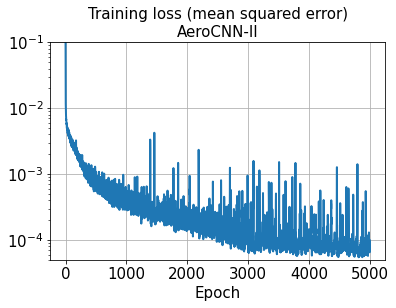

In [28]:
hist = history.history
plt.plot(hist['loss'], lw=2)
plt.title('Training loss (mean squared error)\nAeroCNN-II', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
plt.ylim([5e-5, 1e-1])
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.show()

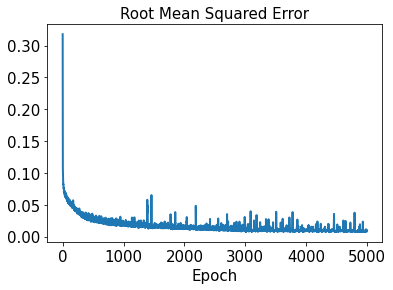

In [29]:
plt.plot(hist['rmse'], lw=2)
plt.title('Root Mean Squared Error', size=15)
plt.xlabel('Epoch', size=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.show()

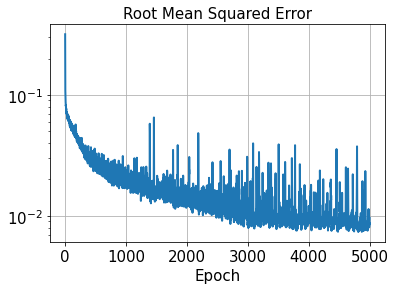

In [30]:
plt.plot(hist['rmse'], lw=2)
plt.title('Root Mean Squared Error', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.show()

In [31]:
test_results = model.evaluate(x_train)

47/47 [==============================] - 0s 2ms/step - loss: 3.3323e-07 - rmse: 0.0000e+00


In [32]:
decoded_train = model.predict(x_train)

47/47 [==============================] - 0s 2ms/step


In [33]:
x_train.shape

(1488, 100, 100, 1)

In [34]:
decoded_test = model.predict(x_test)

20/20 [==============================] - 0s 2ms/step


In [35]:
error_train_abs = np.abs(decoded_train - y_train)

In [36]:
error_test_abs = np.abs(decoded_test - y_test)

In [37]:
error_train_Cl_abs = np.abs(decoded_train[:,0,:] - y_train[:,0,:])

In [38]:
error_train_Cd_abs = np.abs(decoded_train[:,1,:] - y_train[:,1,:])

In [39]:
error_test_Cl_abs = np.abs(decoded_test[:,0,:] - y_test[:,0,:])

In [40]:
error_test_Cd_abs = np.abs(decoded_test[:,1,:] - y_test[:,1,:])

In [41]:
decoded_train.shape

(1488, 2, 1)

In [42]:
os.chdir("D:\\TrainedModels\\20221005")
model.save('AeroCNN-II_25kernel_3CNNlayer_lr1e-04.h5', overwrite=True, include_optimizer=True, save_format='h5')

In [43]:
l2_error_train = np.sqrt(np.sum((decoded_train - y_train)**2) / np.sum(y_train**2))
print(l2_error_train)

0.021807339646259017


In [44]:
l2_error_test = np.sqrt(np.sum((decoded_test - y_test)**2) / np.sum(y_test**2))
print(l2_error_test)

0.20048972310775362


In [45]:
l2_error_Cl_train = np.sqrt(np.sum((decoded_train[:,0,:] - y_train[:,0,:])**2) / np.sum(y_train[:,0,:]**2))
print(l2_error_Cl_train)

0.021493712137258102


In [46]:
l2_error_Cd_train = np.sqrt(np.sum((decoded_train[:,1,:] - y_train[:,1,:])**2) / np.sum(y_train[:,1,:]**2))
print(l2_error_Cd_train)

0.029056447110346124


In [47]:
l2_error_Cl_test = np.sqrt(np.sum((decoded_test[:,0,:] - y_test[:,0,:])**2) / np.sum(y_test[:,0,:]**2))
print(l2_error_Cl_test)

0.19785279286500992


In [48]:
l2_error_Cd_test = np.sqrt(np.sum((decoded_test[:,1,:] - y_test[:,1,:])**2) / np.sum(y_test[:,1,:]**2))
print(l2_error_Cd_test)

0.2567914119254141


In [49]:
l2_error_train_list = []
for i in range(0, len(aa_train)):
    l2_error_train_data = np.sqrt(np.sum((decoded_train[i] - y_train[i])**2) / np.sum(y_train[i]**2))
    l2_error_train_list.append(l2_error_train_data)
print(l2_error_train_list)

[0.02674493221052749, 0.018365024976665742, 0.026141329372826684, 0.1469937389712249, 0.08978591234422036, 0.020237744230832425, 0.017012188806577563, 0.01596725939891486, 0.009993919563712499, 0.01257133803949746, 0.010750903822008736, 0.011999455603517301, 0.008597230597939435, 0.017852034397478813, 0.012490715800043418, 0.010429000240822552, 0.03813425317568368, 0.02236931526777759, 0.028334318369864907, 0.04637858675719612, 0.09677981218679581, 0.04525575635006205, 0.012027743700993365, 0.002046073701263972, 0.015047764830175652, 0.02014475661089342, 0.015611259017730743, 0.01385256380959725, 0.011246352678223798, 0.01600186688325903, 0.006607841618540393, 0.00666579004720129, 0.052993522720031196, 0.03857120626921249, 0.025875718156856693, 0.013415175195643067, 0.11106089743946092, 0.11970732903035425, 0.033768634491404784, 0.002854437199537397, 0.01877129463723185, 0.028556706098149656, 0.02278375976382011, 0.009091328456167499, 0.010205669501738401, 0.006577661462493719, 0.01543

In [50]:
l2_error_test_list = []
for i in range(0, len(aa_test)):
    l2_error_test_data = np.sqrt(np.sum((decoded_test[i] - y_test[i])**2) / np.sum(y_test[i]**2))
    l2_error_test_list.append(l2_error_test_data)
print(l2_error_test_list)

[0.020097455006210328, 0.04146579588021791, 0.011991445891680752, 0.005851957467077599, 0.03603916469078719, 0.16592970698755347, 0.0751929033810082, 0.05616657143073172, 0.052387125661121255, 0.02617870368977896, 0.2760315797497102, 0.03411937999785825, 0.12551672385142978, 0.4923612652888015, 0.23947134721497126, 0.0830072427535715, 0.10515601325084652, 0.05526811772761819, 0.11668531933295852, 0.1687105397829987, 0.177116482652675, 0.15181601935198388, 0.09237047072120935, 0.02164057131443559, 0.004184676427865109, 0.06446214315677087, 0.006132923777043064, 0.016146569707312156, 0.029211815059462416, 0.034855743638754474, 0.1767120130906935, 0.12113898520137874, 0.035512174224787856, 0.018053357495702138, 0.029879390314595532, 0.08749392694500688, 0.2902004679263786, 0.777600250106643, 0.2280812777280422, 0.19068234118880786, 0.1358114244722681, 0.09926927787027061, 0.4665163039138247, 0.17014313789553762, 0.042517225739384844, 0.3675764649014508, 0.005330626881278488, 0.01266105332

In [51]:
l2_error_Cl_train_list = []
for i in range(0, len(aa_train)):
    l2_error_Cl_train_data = np.sqrt(np.sum((decoded_train[:,0,:][i] - y_train[:,0,:][i])**2) / np.sum(y_train[:,0,:][i]**2))
    l2_error_Cl_train_list.append(l2_error_Cl_train_data)
print(l2_error_Cl_train_list)

[0.02671065239244621, 0.018197570868632038, 0.025851549433955616, 0.15047234258443482, 0.09039671723036574, 0.020114700160898027, 0.016786327219190798, 0.015613163261876842, 0.009963797004535736, 0.012553840390289363, 0.010757633941241561, 0.012010647780365251, 0.008591800494500203, 0.01787480914984168, 0.012179146648060576, 0.009005044965611561, 0.038170950573060664, 0.02200072678092867, 0.027696769277617477, 0.04645440368065844, 0.09849803365684041, 0.04552323020653854, 0.004441391701189586, 0.0012662688943923977, 0.01470614006093891, 0.02006080918601557, 0.015535644675095894, 0.013849778734158037, 0.011224833233098268, 0.015971301690826, 0.006616465476173279, 0.000835225993217243, 0.052522893794868034, 0.039131085599571035, 0.023790681218182477, 0.011742257286240853, 0.1116687366863973, 0.11613561886272669, 0.032070067504857636, 0.002724050464892822, 0.01868626937708915, 0.02833020811752455, 0.02286890268188056, 0.006402268580401482, 0.007968795810072883, 0.002516479411351883, 0.016

In [52]:
l2_error_Cd_train_list = []
for i in range(0, len(aa_train)):
    l2_error_Cd_train_data = np.sqrt(np.sum((decoded_train[:,1,:][i] - y_train[:,1,:][i])**2) / np.sum(y_train[:,1,:][i]**2))
    l2_error_Cd_train_list.append(l2_error_Cd_train_data)
print(l2_error_Cd_train_list)

[0.040595829572724604, 0.056531992110755463, 0.06378432753580321, 0.05215591847196118, 0.012185001371054374, 0.050764685813880536, 0.08645402131474816, 0.12198980128287114, 0.0300662322156055, 0.025190284370918577, 0.0028875988261826612, 0.0028281661584972657, 0.010211722693987887, 0.012756715317223699, 0.035329773574141035, 0.04775258725446563, 0.005749334111823456, 0.10737549523706974, 0.14840003009125396, 0.013656840453692217, 0.011248848754884012, 0.02606819373301662, 0.21445502339086625, 0.04408626776953756, 0.09783357262084388, 0.054967961709563085, 0.037735299173592037, 0.014708292737323327, 0.014546297686604346, 0.019538088009970207, 0.005899121335381862, 0.0466086518059457, 0.06070063472059742, 0.002866667315004664, 0.12939034782244957, 0.12294206280564238, 0.008614761485546001, 0.21296365275894935, 0.22381807521384364, 0.026526890161558417, 0.056792393364129834, 0.0644709152517759, 0.012381824951046564, 0.029853423784722374, 0.024791014253094056, 0.019693971171302324, 0.00905

In [53]:
np.sqrt(np.sum((decoded_train[:,1,:][36] - y_train[:,1,:][36])**2) / np.sum(y_train[:,1,:][36]**2))

0.008614761485546001

In [54]:
l2_error_Cl_test_list = []
for i in range(0, len(aa_test)):
    l2_error_Cl_test_data = np.sqrt(np.sum((decoded_test[:,0,:][i] - y_test[:,0,:][i])**2) / np.sum(y_test[:,0,:][i]**2))
    l2_error_Cl_test_list.append(l2_error_Cl_test_data)
print(l2_error_Cl_test_list)

[0.020563113615485767, 0.040002334369565185, 0.005555560037274828, 0.001861497476491097, 0.03620395156040059, 0.1687954781719701, 0.07528171122894307, 0.05605136232360425, 0.05190815288330763, 0.0214693893641136, 0.27889908487120063, 0.03500745356282763, 0.12832376907344764, 0.4978876711914831, 0.24513397647763813, 0.08581810141146605, 0.10467709574523579, 0.055283149852964016, 0.11674263702151778, 0.169140602469836, 0.0009887083309116794, 0.15186366504547452, 0.09231625308906415, 0.01965364666142114, 0.0041515806445937215, 0.06291668485857374, 0.006128937058658363, 0.016101738650417682, 0.026472335160782273, 0.03433568781779271, 0.1767211641807753, 0.10802515955505905, 0.03548207245398448, 0.011562829162814203, 0.029881292018928914, 0.08740745716096202, 0.29118257958498717, 0.793306916821971, 0.2280621174013765, 0.1907245181030917, 0.13584358668613392, 0.09933783855518745, 0.4692545123535484, 0.1718602442292584, 0.04237256147891383, 0.3716958654717895, 0.00020120159082191136, 0.003363

In [55]:
l2_error_Cd_test_list = []
for i in range(0, len(aa_test)):
    l2_error_Cd_test_data = np.sqrt(np.sum((decoded_test[:,1,:][i] - y_test[:,1,:][i])**2) / np.sum(y_test[:,1,:][i]**2))
    l2_error_Cd_test_list.append(l2_error_Cd_test_data)
print(l2_error_Cd_test_list)

[0.006478617484572645, 0.07702481736149817, 0.14217667054379707, 0.10537842247599348, 0.012574210471294504, 0.04839757625253373, 0.009302142334665092, 0.11773255415493204, 0.17878017122397954, 0.21022571764179046, 0.16187948427469323, 0.007425884911417576, 0.0815085511665481, 0.4355306505755299, 0.18542044638838653, 0.061646289553180515, 0.32323142656329956, 0.03988226227460873, 0.0769756140909661, 0.02128226419690832, 0.245997398651016, 0.14386682625741418, 0.12265032033659373, 0.32154314993023475, 0.02194609286356791, 0.5889510892681831, 0.010365674270206876, 0.03922723771823978, 0.23577771668557843, 0.0695864930969027, 0.17649461246200931, 0.17653333535732627, 0.03605247297952672, 0.0898529301883013, 0.029431560590162196, 0.12082085178740402, 0.13620409986339846, 0.06233466788627065, 0.23574324846277542, 0.1449552384707147, 0.09303357049321813, 0.062318751636908365, 0.15055895097074976, 0.1325479690475881, 0.044492433782019024, 0.31635343475831473, 0.016675358502573286, 0.0349030440

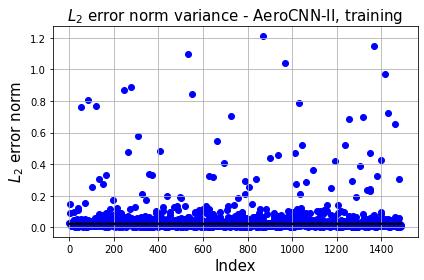

In [56]:
plt.plot(np.linspace(1, aa_train.shape[0], aa_train.shape[0]),
         l2_error_train*np.ones(aa_train.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_train.shape[0], aa_train.shape[0]), l2_error_train_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.title('$L_2$ error norm variance - AeroCNN-II, training', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

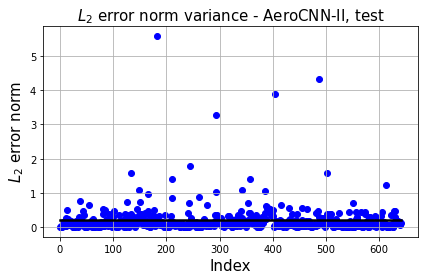

In [57]:
plt.plot(np.linspace(1, aa_test.shape[0], aa_test.shape[0]),
         l2_error_test*np.ones(aa_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_test.shape[0], aa_test.shape[0]), l2_error_test_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.title('$L_2$ error norm variance - AeroCNN-II, test', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

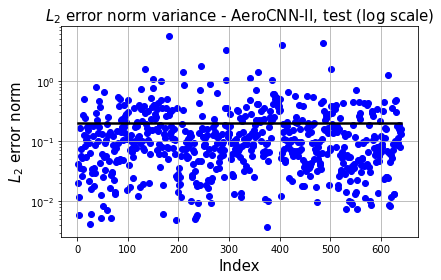

In [58]:
plt.plot(np.linspace(1, aa_test.shape[0], aa_test.shape[0]),
         l2_error_test*np.ones(aa_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_test.shape[0], aa_test.shape[0]), l2_error_test_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm variance - AeroCNN-II, test (log scale)', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

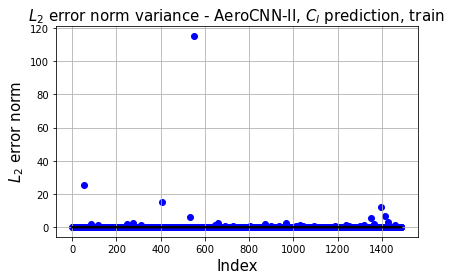

In [59]:
plt.plot(np.linspace(1, aa_train.shape[0], aa_train.shape[0]),
         l2_error_Cl_train*np.ones(aa_train.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_train.shape[0], aa_train.shape[0]), l2_error_Cl_train_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.title('$L_2$ error norm variance - AeroCNN-II, $C_l$ prediction, train', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

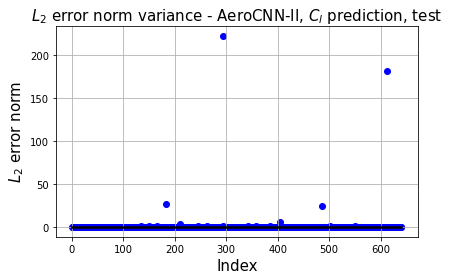

In [60]:
plt.plot(np.linspace(1, aa_test.shape[0], aa_test.shape[0]),
         l2_error_Cl_test*np.ones(aa_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_test.shape[0], aa_test.shape[0]), l2_error_Cl_test_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.title('$L_2$ error norm variance - AeroCNN-II, $C_l$ prediction, test', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

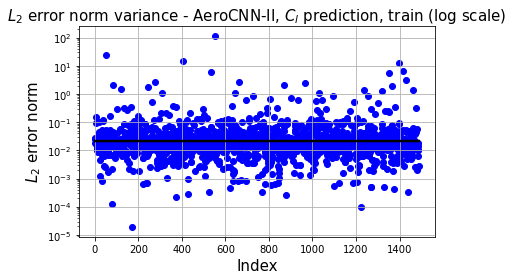

In [61]:
plt.plot(np.linspace(1, aa_train.shape[0], aa_train.shape[0]),
         l2_error_Cl_train*np.ones(aa_train.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_train.shape[0], aa_train.shape[0]), l2_error_Cl_train_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm variance - AeroCNN-II, $C_l$ prediction, train (log scale)', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

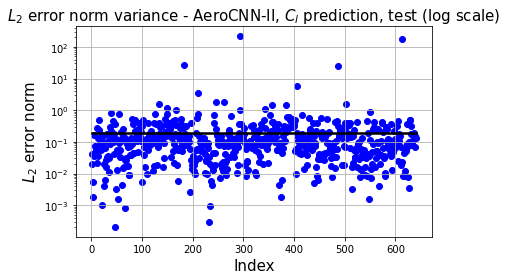

In [62]:
plt.plot(np.linspace(1, aa_test.shape[0], aa_test.shape[0]),
         l2_error_Cl_test*np.ones(aa_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_test.shape[0], aa_test.shape[0]), l2_error_Cl_test_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm variance - AeroCNN-II, $C_l$ prediction, test (log scale)', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

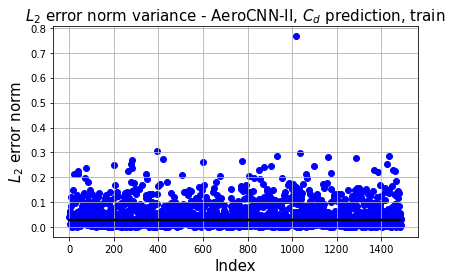

In [63]:
plt.plot(np.linspace(1, aa_train.shape[0], aa_train.shape[0]),
         l2_error_Cd_train*np.ones(aa_train.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_train.shape[0], aa_train.shape[0]), l2_error_Cd_train_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.title('$L_2$ error norm variance - AeroCNN-II, $C_d$ prediction, train', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

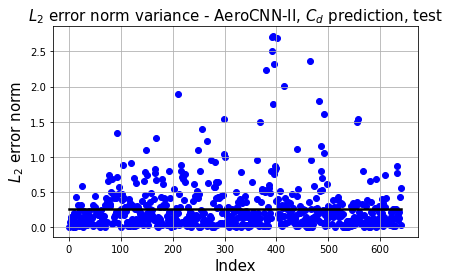

In [64]:
plt.plot(np.linspace(1, aa_test.shape[0], aa_test.shape[0]),
         l2_error_Cd_test*np.ones(aa_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_test.shape[0], aa_test.shape[0]), l2_error_Cd_test_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.title('$L_2$ error norm variance - AeroCNN-II, $C_d$ prediction, test', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

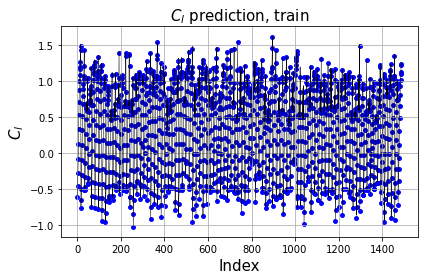

In [65]:
plt.plot(np.linspace(1, decoded_train.shape[0], decoded_train.shape[0]), y_train[:,0,:], 'k',lw=0.5)
plt.scatter(np.linspace(1, decoded_train.shape[0], decoded_train.shape[0]), decoded_train[:,0,:], c='b', s=15)
plt.xlabel('Index', fontsize=15)
plt.ylabel('$C_l$', fontsize=15)
plt.title(r'$C_l$ prediction, train', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

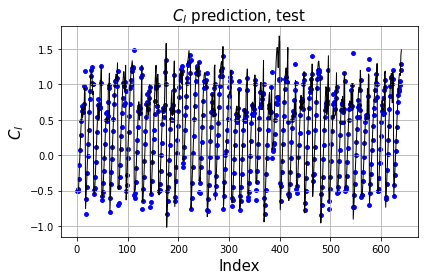

In [66]:
plt.plot(np.linspace(1, decoded_test.shape[0], decoded_test.shape[0]), y_test[:,0,:], 'k',lw=1)
plt.scatter(np.linspace(1, decoded_test.shape[0], decoded_test.shape[0]), decoded_test[:,0,:], c='b', s=15)
plt.xlabel('Index', fontsize=15)
plt.ylabel('$C_l$', fontsize=15)
plt.title(r'$C_l$ prediction, test', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

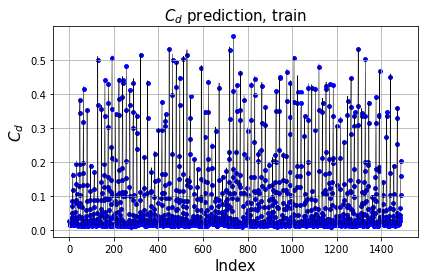

In [67]:
plt.plot(np.linspace(1, decoded_train.shape[0], decoded_train.shape[0]), y_train[:,1,:], 'k',lw=0.5)
plt.scatter(np.linspace(1, decoded_train.shape[0], decoded_train.shape[0]), decoded_train[:,1,:], c='b', s=15)
plt.xlabel('Index', fontsize=15)
plt.ylabel('$C_d$', fontsize=15)
plt.title(r'$C_d$ prediction, train', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

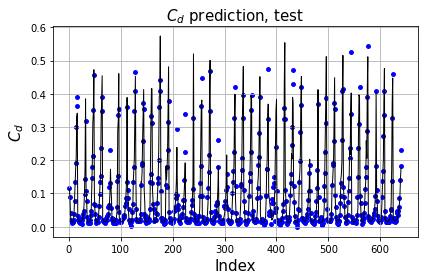

In [68]:
plt.plot(np.linspace(1, decoded_test.shape[0], decoded_test.shape[0]), y_test[:,1,:], 'k',lw=1)
plt.scatter(np.linspace(1, decoded_test.shape[0], decoded_test.shape[0]), decoded_test[:,1,:], c='b', s=15)
plt.xlabel('Index', fontsize=15)
plt.ylabel('$C_d$', fontsize=15)
plt.title(r'$C_d$ prediction, test', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

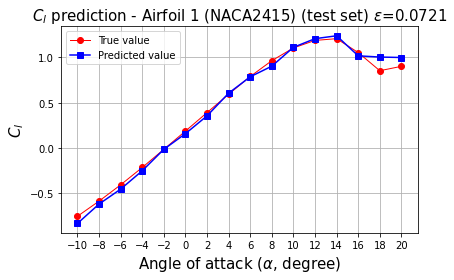

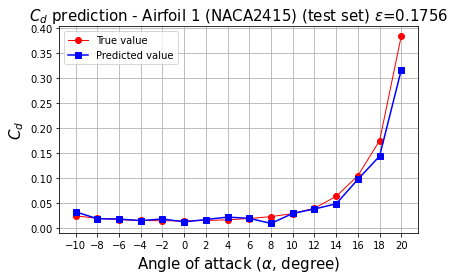

In [69]:
airfoiltest1_predict = decoded_test[16*1:16*2]

airfoiltest1_cl=y_test[16*1:16*2,0,:]
airfoiltest1_cd=y_test[16*1:16*2,1,:]

epsilonCl = np.sqrt(np.sum((airfoiltest1_predict[:,0,:] - airfoiltest1_cl)**2) / np.sum(airfoiltest1_cl**2))
epsilonCd = np.sqrt(np.sum((airfoiltest1_predict[:,1,:] - airfoiltest1_cd)**2) / np.sum(airfoiltest1_cd**2))

plt.plot(alpha, airfoiltest1_cl.reshape(16,), 'r', marker='o', lw=1)
plt.plot(alpha, airfoiltest1_predict[:,0,:].reshape(16,), c='b', marker='s')
plt.xlabel(r'Angle of attack ($\alpha$, degree)', fontsize=15)
plt.ylabel('$C_l$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title(r'$C_l$ prediction - Airfoil 1 (%s) (test set) $\epsilon$=%.4f' % (str(geo_test[1*16][0])[2:-1], epsilonCl), fontsize=15)
plt.legend(['True value', 'Predicted value'])
plt.grid()
plt.tight_layout()
plt.show()

plt.plot(alpha, airfoiltest1_cd.reshape(16,), 'r', marker='o', lw=1)
plt.plot(alpha, airfoiltest1_predict[:,1,:].reshape(16,), c='b', marker='s')
plt.xlabel(r'Angle of attack ($\alpha$, degree)', fontsize=15)
plt.ylabel('$C_d$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title(r'$C_d$ prediction - Airfoil 1 (%s) (test set) $\epsilon$=%.4f' % (str(geo_test[1*16][0])[2:-1], epsilonCd), fontsize=15)
plt.legend(['True value', 'Predicted value'])
plt.grid()
plt.tight_layout()
plt.show()

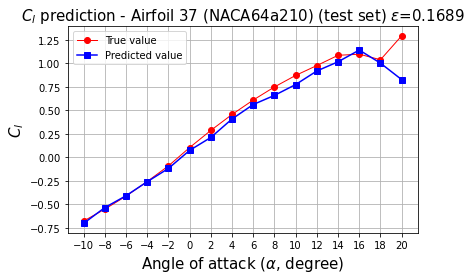

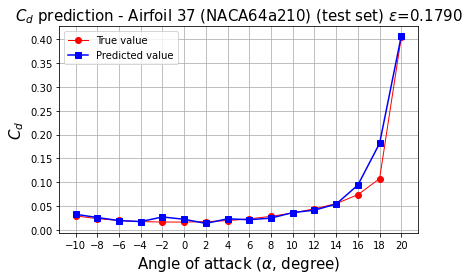

In [71]:
airfoiltest37_predict = decoded_test[16*36:16*37]

airfoiltest37_cl=y_test[16*36:16*37,0,:]
airfoiltest37_cd=y_test[16*36:16*37,1,:]

epsilonCl = np.sqrt(np.sum((airfoiltest37_predict[:,0,:] - airfoiltest37_cl)**2) / np.sum(airfoiltest37_cl**2))
epsilonCd = np.sqrt(np.sum((airfoiltest37_predict[:,1,:] - airfoiltest37_cd)**2) / np.sum(airfoiltest37_cd**2))

plt.plot(alpha, airfoiltest37_cl.reshape(16,), 'r', marker='o',lw=1)
plt.plot(alpha, airfoiltest37_predict[:,0,:].reshape(16,), c='b', marker='s')
plt.xlabel(r'Angle of attack ($\alpha$, degree)', fontsize=15)
plt.ylabel('$C_l$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title(r'$C_l$ prediction - Airfoil 37 (%s) (test set) $\epsilon$=%.4f' % (str(geo_test[37*16][0])[2:-1], epsilonCl), fontsize=15)
plt.legend(['True value', 'Predicted value'])
plt.grid()
plt.tight_layout()
plt.show()

plt.plot(alpha, airfoiltest37_cd.reshape(16,), 'r', marker='o', lw=1)
plt.plot(alpha, airfoiltest37_predict[:,1,:].reshape(16,), c='b', marker='s')
plt.xlabel(r'Angle of attack ($\alpha$, degree)', fontsize=15)
plt.ylabel('$C_d$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title(r'$C_d$ prediction - Airfoil 37 (%s) (test set) $\epsilon$=%.4f' % (str(geo_test[37*16][0])[2:-1], epsilonCd), fontsize=15)
plt.legend(['True value', 'Predicted value'])
plt.grid()
plt.tight_layout()
plt.show()

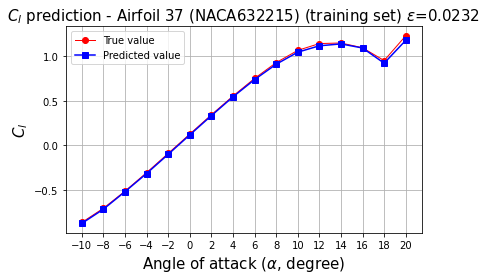

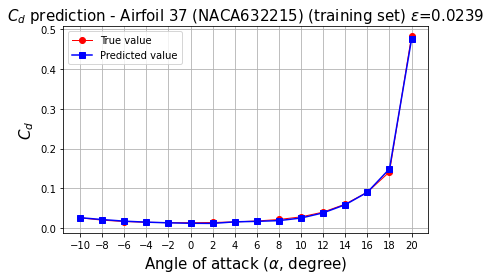

In [72]:
airfoiltrain37_predict = decoded_train[16*36:16*37]

airfoiltrain37_cl=y_train[16*36:16*37,0,:]
airfoiltrain37_cd=y_train[16*36:16*37,1,:]

epsilonCl = np.sqrt(np.sum((airfoiltrain37_predict[:,0,:] - airfoiltrain37_cl)**2) / np.sum(airfoiltrain37_cl**2))
epsilonCd = np.sqrt(np.sum((airfoiltrain37_predict[:,1,:] - airfoiltrain37_cd)**2) / np.sum(airfoiltrain37_cd**2))

plt.plot(alpha, airfoiltrain37_cl.reshape(16,), 'r', marker='o', lw=1)
plt.plot(alpha, airfoiltrain37_predict[:,0,:].reshape(16,), c='b', marker='s')
plt.xlabel(r'Angle of attack ($\alpha$, degree)', fontsize=15)
plt.ylabel('$C_l$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title('$C_l$ prediction - Airfoil 37 (%s) (training set) $\epsilon$=%.4f' % (str(geo_train[36*16][0])[2:-1], epsilonCl), fontsize=15)
plt.legend(['True value', 'Predicted value'])
plt.grid()
plt.tight_layout()
plt.show()

plt.plot(alpha, airfoiltrain37_cd.reshape(16,), 'r', marker='o', lw=1)
plt.plot(alpha, airfoiltrain37_predict[:,1,:].reshape(16,), c='b', marker='s')
plt.xlabel(r'Angle of attack ($\alpha$, degree)', fontsize=15)
plt.ylabel('$C_d$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title('$C_d$ prediction - Airfoil 37 (%s) (training set) $\epsilon$=%.4f' % (str(geo_train[36*16][0])[2:-1], epsilonCd), fontsize=15)
plt.legend(['True value', 'Predicted value'])
plt.grid()
plt.tight_layout()
plt.show()

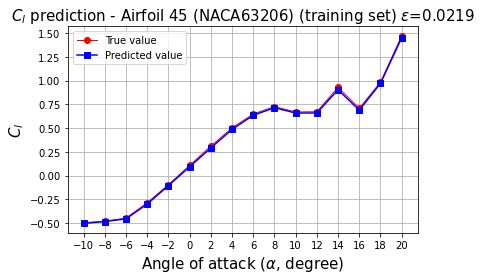

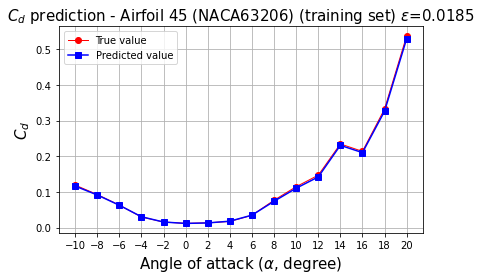

In [73]:
airfoiltrain45_predict = decoded_train[16*44:16*45]

airfoiltrain45_cl=y_train[16*44:16*45,0,:]
airfoiltrain45_cd=y_train[16*44:16*45,1,:]

epsilonCl = np.sqrt(np.sum((airfoiltrain45_predict[:,0,:] - airfoiltrain45_cl)**2) / np.sum(airfoiltrain45_cl**2))
epsilonCd = np.sqrt(np.sum((airfoiltrain45_predict[:,1,:] - airfoiltrain45_cd)**2) / np.sum(airfoiltrain45_cd**2))

plt.plot(alpha, airfoiltrain45_cl.reshape(16,), 'r', marker='o', lw=1)
plt.plot(alpha, airfoiltrain45_predict[:,0,:].reshape(16,), c='b', marker='s')
plt.xlabel(r'Angle of attack ($\alpha$, degree)', fontsize=15)
plt.ylabel('$C_l$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title(r'$C_l$ prediction - Airfoil 45 (%s) (training set) $\epsilon$=%.4f' % (str(geo_train[44*16][0])[2:-1], epsilonCl),
          fontsize=15)
plt.legend(['True value', 'Predicted value'])
plt.grid()
plt.tight_layout()
plt.show()

plt.plot(alpha, airfoiltrain45_cd.reshape(16,), 'r', marker='o', lw=1)
plt.plot(alpha, airfoiltrain45_predict[:,1,:].reshape(16,), c='b', marker='s')
plt.xlabel(r'Angle of attack ($\alpha$, degree)', fontsize=15)
plt.ylabel('$C_d$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title(r'$C_d$ prediction - Airfoil 45 (%s) (training set) $\epsilon$=%.4f' % (str(geo_train[44*16][0])[2:-1], epsilonCd),
          fontsize=15)
plt.legend(['True value', 'Predicted value'])
plt.grid()
plt.tight_layout()
plt.show()

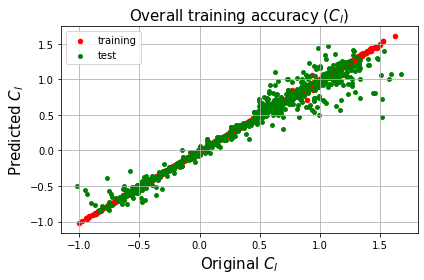

In [74]:
plt.scatter(y_train[:,0,:], decoded_train[:,0,:], c='r', s=20)
plt.scatter(y_test[:,0,:], decoded_test[:,0,:], c='g', s=15)
plt.xlabel('Original $C_l$', fontsize=15)
plt.ylabel('Predicted $C_l$', fontsize=15)
plt.title('Overall training accuracy ($C_l$)', fontsize=15)

plt.grid()
plt.legend(['training', 'test'])
plt.tight_layout()
plt.show()

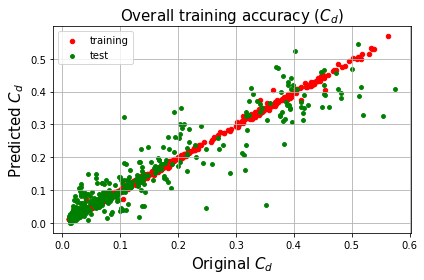

In [75]:
plt.scatter(y_train[:,1,:], decoded_train[:,1,:], c='r', s=20)
plt.scatter(y_test[:,1,:], decoded_test[:,1,:], c='g', s=15)
plt.xlabel('Original $C_d$', fontsize=15)
plt.ylabel('Predicted $C_d$', fontsize=15)
plt.title('Overall training accuracy ($C_d$)', fontsize=15)
plt.grid()
plt.legend(['training', 'test'])
plt.tight_layout()
plt.show()

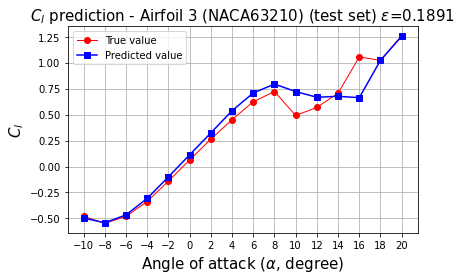

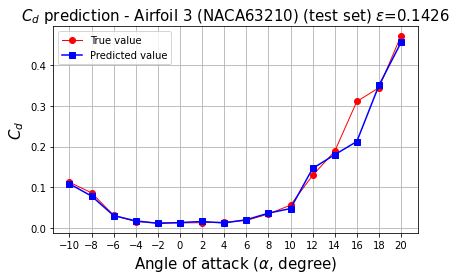

In [76]:
airfoiltest3_predict = decoded_test[16*2:16*3]

airfoiltest3_cl=y_test[16*2:16*3,0,:]
airfoiltest3_cd=y_test[16*2:16*3,1,:]

epsilonCl = np.sqrt(np.sum((airfoiltest3_predict[:,0,:] - airfoiltest3_cl)**2) / np.sum(airfoiltest3_cl**2))
epsilonCd = np.sqrt(np.sum((airfoiltest3_predict[:,1,:] - airfoiltest3_cd)**2) / np.sum(airfoiltest3_cd**2))

plt.plot(alpha, airfoiltest3_cl.reshape(16,), 'r', marker='o', lw=1)
plt.plot(alpha, airfoiltest3_predict[:,0,:].reshape(16,), marker='s', c='b')
plt.xlabel(r'Angle of attack ($\alpha$, degree)', fontsize=15)
plt.ylabel('$C_l$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title(r'$C_l$ prediction - Airfoil 3 (%s) (test set) $\epsilon$=%.4f' % (str(geo_test[2*16][0])[2:-1], epsilonCl), fontsize=15)
plt.legend(['True value', 'Predicted value'])
plt.grid()
plt.tight_layout()
plt.show()

plt.plot(alpha, airfoiltest3_cd.reshape(16,), 'r', marker='o', lw=1)
plt.plot(alpha, airfoiltest3_predict[:,1,:].reshape(16,), marker='s',c='b')
plt.xlabel(r'Angle of attack ($\alpha$, degree)', fontsize=15)
plt.ylabel('$C_d$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title(r'$C_d$ prediction - Airfoil 3 (%s) (test set) $\epsilon$=%.4f' % (str(geo_test[2*16][0])[2:-1], epsilonCd), fontsize=15)
plt.legend(['True value', 'Predicted value'])
plt.grid()
plt.tight_layout()
plt.show()

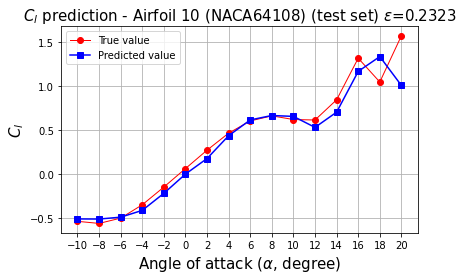

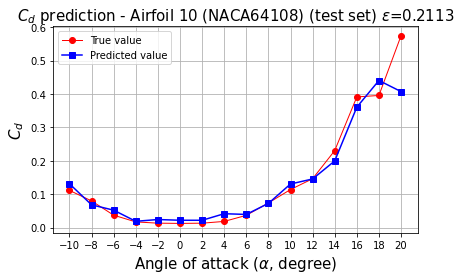

In [77]:
airfoiltest11_predict = decoded_test[16*10:16*11]

airfoiltest11_cl=y_test[16*10:16*11,0,:]
airfoiltest11_cd=y_test[16*10:16*11,1,:]

epsilonCl = np.sqrt(np.sum((airfoiltest11_predict[:,0,:] - airfoiltest11_cl)**2) / np.sum(airfoiltest11_cl**2))
epsilonCd = np.sqrt(np.sum((airfoiltest11_predict[:,1,:] - airfoiltest11_cd)**2) / np.sum(airfoiltest11_cd**2))

plt.plot(alpha, airfoiltest11_cl.reshape(16,), c='r', marker='o', lw=1)
plt.plot(alpha, airfoiltest11_predict[:,0,:].reshape(16,), c='b', marker='s')
plt.xlabel(r'Angle of attack ($\alpha$, degree)', fontsize=15)
plt.ylabel('$C_l$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title(r'$C_l$ prediction - Airfoil 10 (%s) (test set) $\epsilon$=%.4f' % (str(geo_test[10*16][0])[2:-1], epsilonCl), fontsize=15)
plt.legend(['True value', 'Predicted value'])
plt.grid()
plt.tight_layout()
plt.show()

plt.plot(alpha, airfoiltest11_cd.reshape(16,), c='r', marker='o', lw=1)
plt.plot(alpha, airfoiltest11_predict[:,1,:].reshape(16,), c='b', marker='s')
plt.xlabel(r'Angle of attack ($\alpha$, degree)', fontsize=15)
plt.ylabel('$C_d$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title(r'$C_d$ prediction - Airfoil 10 (%s) (test set) $\epsilon$=%.4f' % (str(geo_test[10*16][0])[2:-1], epsilonCd), fontsize=15)
plt.legend(['True value', 'Predicted value'])
plt.grid()
plt.tight_layout()
plt.show()